# Exploratory Analysis
This notebook contains code for analyzing every feature individually (univariate analysis) and also multiple features (multivariate analysis).

Decisions for preprocessing are documented here and performed in data_preprocessing.ipynb.

## 0. Data Loading and Libraries

In [193]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
import itertools

In [194]:
# Loading data
df_train = pd.read_csv("train_data.csv")
df_test = pd.read_csv("test_data.csv")

C:\Users\ritae\AppData\Local\Temp\ipykernel_10612\1322224829.py:2: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv("train_data.csv")


## Helper functions

In [195]:
def convert_dates(df, date_columns):
    """Convert specified columns to datetime."""
    for col in date_columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')

In [196]:
def basic_descriptive_stats(df):
    """Display basic descriptive statistics for a DataFrame."""
    print("First 5 rows:")
    display(df.head())
    print("\nData Info:")
    display(df.info())
    print("\nNumerical Features Description:")
    display(df.describe())
    print("\nCategorical Features Description:")
    display(df.describe(include=['object', 'category']))
    print("\nMissing Values Summary:")
    print(df.isna().sum())
    print("\nDuplicate Check:")
    print(f"Number of duplicates: {df.duplicated().sum()}")


In [197]:
def feature_splitting(df, threshold=25):
    """Splits the DataFrame columns into date, categorical, high cardinality categorical, and numerical features."""
    date_features = [col for col in df.columns if 'Date' in col]
    non_metric_features = df.select_dtypes(include=['object', 'category']).columns.tolist()
    non_metric_high_cardinality = [col for col in non_metric_features if df[col].nunique() > threshold]
    metric_features = df.select_dtypes(include=[np.number]).columns.tolist()

    print("Non-metric (Categorical) features:", non_metric_features)
    print("Non-metric (High Cardinality) features:", non_metric_high_cardinality)
    print("Metric (Numerical) features:", metric_features)

    return date_features, non_metric_features, non_metric_high_cardinality, metric_features

# Use for both train and test sets
date_features, non_metric_features, non_metric_high_cardinality, metric_features = feature_splitting(df_train)


Non-metric (Categorical) features: ['Accident Date', 'Alternative Dispute Resolution', 'Assembly Date', 'Attorney/Representative', 'C-2 Date', 'C-3 Date', 'Carrier Name', 'Carrier Type', 'Claim Injury Type', 'County of Injury', 'COVID-19 Indicator', 'District Name', 'First Hearing Date', 'Gender', 'Industry Code Description', 'Medical Fee Region', 'WCIO Cause of Injury Description', 'WCIO Nature of Injury Description', 'WCIO Part Of Body Description', 'Zip Code', 'WCB Decision']
Non-metric (High Cardinality) features: ['Accident Date', 'Assembly Date', 'C-2 Date', 'C-3 Date', 'Carrier Name', 'County of Injury', 'First Hearing Date', 'WCIO Cause of Injury Description', 'WCIO Nature of Injury Description', 'WCIO Part Of Body Description', 'Zip Code']
Metric (Numerical) features: ['Age at Injury', 'Average Weekly Wage', 'Birth Year', 'Claim Identifier', 'IME-4 Count', 'Industry Code', 'OIICS Nature of Injury Description', 'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code', 'WCIO Pa

In [198]:
def check_missing_patterns(df, columns_to_check):
    """Checks if certain variables have all their missing values in the same rows."""
    for col in columns_to_check:
        missing_rows = df[df[col].isna()][columns_to_check]
        display(missing_rows.info())


In [199]:
def num_dist(df, metric_features, bins=30):
    """Display histograms of numerical features."""
    df[metric_features].hist(bins=bins, figsize=(15, 10))
    plt.suptitle("Distribution of Numerical Variables")
    plt.show()


In [200]:
def cat_counts_and_plots(df, excl_feat=[]):
    """Display value counts and plots for categorical features, excluding high cardinality features if needed."""
    for column in df.select_dtypes(include='object').columns:
        if column not in excl_feat:
            print(f"Value counts for {column}:")
            print(df[column].value_counts())
            print("\n")

            plt.figure(figsize=(10, 6))
            sns.countplot(data=df, x=column, order=df[column].value_counts().index)
            plt.title(f"Count of {column}")
            plt.xticks(rotation=90)
            plt.show()


In [201]:
def plot_bar(df, col, degrees=0):
    """Plot a bar chart for a specified column."""
    column = df[col].value_counts()
    plt.figure(figsize=(10, 6))
    sns.barplot(x=column.index.astype(str), y=column.values)
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.xticks(rotation=degrees)
    plt.show()

def plot_scatter_all_subplots(df, numerical_columns, ncols=3):
    """
    Plot scatter plots for all pairs of numerical columns in subplots.
    
    Args:
    df (DataFrame): The data frame containing the numerical columns.
    numerical_columns (list): List of numerical column names to plot.
    ncols (int): Number of columns in the subplot grid (default is 3).
    """
    
    # Generate all possible pairs of numerical columns
    pairs = list(itertools.combinations(numerical_columns, 2))
    
    # Calculate the number of rows needed for the subplots
    nrows = (len(pairs) // ncols) + (1 if len(pairs) % ncols != 0 else 0)
    
    # Create subplots
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 5, nrows * 5))
    
    # Flatten the axes array for easier iteration
    axes = axes.flatten()
    
    # Create a scatter plot for each pair of variables
    for i, (col1, col2) in enumerate(pairs):
        ax = axes[i]  # Get the corresponding axis for this subplot
        sns.scatterplot(data=df_filtered, x=col1, y=col2, ax=ax)
        ax.set_title(f'{col1} vs {col2}')
        ax.set_xlabel(col1)
        ax.set_ylabel(col2)
    
    # Turn off any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

def plot_hist(df, col, rotate=False):
    """Plot a histogram for a specified column with KDE."""
    plt.figure(figsize=(10, 6))
    sns.histplot(df[col], bins=30, kde=True)
    plt.xlabel(col)
    plt.ylabel("Frequency")
    if rotate:
        plt.xticks(rotation=45)
    plt.show()

def plot_box(df, col):
    """Plot a boxplot for a specified column."""
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df[col])
    plt.xlabel(col)
    plt.show()

def plot_pie(df, col):
    """Plot a pie chart for a specified column with percentage thresholds."""
    value_counts = df[col].value_counts()
    total = value_counts.sum()
    percentages = (value_counts / total) * 100

    above_threshold = percentages[percentages >= 2]
    below_threshold = percentages[percentages < 2]

    if len(below_threshold) > 0:
        other_percentage = below_threshold.sum()
        above_threshold['Others'] = other_percentage

    plt.figure(figsize=(8, 8))
    above_threshold.plot.pie(autopct='%1.1f%%', startangle=90, labels=above_threshold.index)
    plt.ylabel("")
    plt.xlabel(col)
    plt.legend(title="Legend", loc='upper left')
    plt.show()

def plot_heatmap(df, numerical_features):
    """Display heatmap of correlation among numerical features."""
    plt.figure(figsize=(12, 10))
    sns.heatmap(data=df[numerical_features].corr(method='spearman'), annot=True, cmap="coolwarm", fmt='.1f')
    plt.show()


In [202]:
def detect_outliers_in_column(df, column, threshold=1.5):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

In [203]:
# NEW
def cast_code_columns(df, code_identifiers=['Code']):
    """
    Cast columns with names containing keywords (e.g., 'Code') to categorical data type, ignoring case.

    Parameters:
        df (pd.DataFrame): The DataFrame to modify.
        code_identifiers (list): List of keywords to identify code columns. Default is ['Code'].

    Returns:
        pd.DataFrame: The modified DataFrame with code columns cast to categorical.
    """
    # Convert code_identifiers to lowercase for case-insensitive matching
    code_identifiers = [keyword.lower() for keyword in code_identifiers]

    # Loop through columns to find those that match code identifiers, case-insensitively
    for col in df.columns:
        if any(keyword in col.lower() for keyword in code_identifiers):
            # Check if the column is currently numeric, then cast to category
            if pd.api.types.is_numeric_dtype(df[col]):
                df[col] = df[col].astype('category')
                print(f"Column '{col}' cast to 'category' data type.")
            else:
                print(f"Column '{col}' already non-numeric, no casting applied.")

    return df

In [204]:
# Define date columns
date_columns = ['Accident Date', 'Assembly Date', 'C-2 Date', 'C-3 Date', 'First Hearing Date']
convert_dates(df_train, date_columns)
convert_dates(df_test, date_columns)

Since our predictive models only work with integer numbers, it is necessary to transform all dates in datetime format into integer numbers. The goal is to have the dates defined as the number of days that have passed since the first date in each of these columns.

In [205]:
# Function to calculate the number of days since the first date
def transform_to_integers(df, date_columns):
    """Convert date columns to the number of days since the first date in each column."""
    for column in date_columns:
        first_date = df[column].min()  # Get the first date in the column
        df[column] = (df[column] - first_date).dt.days  # Calculate days since the first date

In [206]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593471 entries, 0 to 593470
Data columns (total 33 columns):
 #   Column                              Non-Null Count   Dtype         
---  ------                              --------------   -----         
 0   Accident Date                       570337 non-null  datetime64[ns]
 1   Age at Injury                       574026 non-null  float64       
 2   Alternative Dispute Resolution      574026 non-null  object        
 3   Assembly Date                       593471 non-null  datetime64[ns]
 4   Attorney/Representative             574026 non-null  object        
 5   Average Weekly Wage                 545375 non-null  float64       
 6   Birth Year                          544948 non-null  float64       
 7   C-2 Date                            559466 non-null  datetime64[ns]
 8   C-3 Date                            187245 non-null  datetime64[ns]
 9   Carrier Name                        574026 non-null  object        
 10  Carrier 

In [207]:
df_train = cast_code_columns(df_train)
df_test = cast_code_columns(df_test)

Column 'Industry Code' cast to 'category' data type.
Column 'Industry Code Description' already non-numeric, no casting applied.
Column 'WCIO Cause of Injury Code' cast to 'category' data type.
Column 'WCIO Nature of Injury Code' cast to 'category' data type.
Column 'WCIO Part Of Body Code' cast to 'category' data type.
Column 'Zip Code' already non-numeric, no casting applied.
Column 'Industry Code' cast to 'category' data type.
Column 'Industry Code Description' already non-numeric, no casting applied.
Column 'WCIO Cause of Injury Code' cast to 'category' data type.
Column 'WCIO Nature of Injury Code' cast to 'category' data type.
Column 'WCIO Part Of Body Code' cast to 'category' data type.
Column 'Zip Code' already non-numeric, no casting applied.


## General descr. stats

In [208]:
basic_descriptive_stats(df_train)

First 5 rows:


,Accident Date,Age at Injury,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,...,WCIO Cause of Injury Code,WCIO Cause of Injury Description,WCIO Nature of Injury Code,WCIO Nature of Injury Description,WCIO Part Of Body Code,WCIO Part Of Body Description,Zip Code,Agreement Reached,WCB Decision,Number of Dependents
0,2019-12-30,31.0,N,2020-01-01,N,0.00,1988.0,2019-12-31,NaT,NEW HAMPSHIRE INSURANCE CO,...,27.0,FROM LIQUID OR GREASE SPILLS,10.0,CONTUSION,62.0,BUTTOCKS,13662,0.0,Not Work Related,1.0
1,2019-08-30,46.0,N,2020-01-01,Y,1745.93,1973.0,2020-01-01,2020-01-14,ZURICH AMERICAN INSURANCE CO,...,97.0,REPETITIVE MOTION,49.0,SPRAIN OR TEAR,38.0,SHOULDER(S),14569,1.0,Not Work Related,4.0
2,2019-12-06,40.0,N,2020-01-01,N,1434.80,1979.0,2020-01-01,NaT,INDEMNITY INSURANCE CO OF,...,79.0,OBJECT BEING LIFTED OR HANDLED,7.0,CONCUSSION,10.0,MULTIPLE HEAD INJURY,12589,0.0,Not Work Related,6.0
3,NaT,NaN,NaN,2020-01-01,NaN,NaN,NaN,NaT,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-12-30,61.0,N,2020-01-01,N,NaN,1958.0,2019-12-31,NaT,STATE INSURANCE FUND,...,16.0,"HAND TOOL, UTENSIL; NOT POWERED",43.0,PUNCTURE,36.0,FINGER(S),12603,0.0,Not Work Related,1.0



Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593471 entries, 0 to 593470
Data columns (total 33 columns):
 #   Column                              Non-Null Count   Dtype         
---  ------                              --------------   -----         
 0   Accident Date                       570337 non-null  datetime64[ns]
 1   Age at Injury                       574026 non-null  float64       
 2   Alternative Dispute Resolution      574026 non-null  object        
 3   Assembly Date                       593471 non-null  datetime64[ns]
 4   Attorney/Representative             574026 non-null  object        
 5   Average Weekly Wage                 545375 non-null  float64       
 6   Birth Year                          544948 non-null  float64       
 7   C-2 Date                            559466 non-null  datetime64[ns]
 8   C-3 Date                            187245 non-null  datetime64[ns]
 9   Carrier Name                        574026 non-null  object        
 

None


Numerical Features Description:


,Accident Date,Age at Injury,Assembly Date,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Claim Identifier,First Hearing Date,IME-4 Count,OIICS Nature of Injury Description,Agreement Reached,Number of Dependents
count,570337,574026.000000,593471,5.453750e+05,544948.000000,559466,187245,5.934710e+05,150798,132803.000000,0.0,574026.000000,574026.000000
mean,2021-04-28 21:00:27.892982784,42.114270,2021-07-19 03:25:38.260841728,4.910883e+02,1886.767604,2021-07-16 20:11:19.865443328,2021-07-26 21:31:28.449891840,2.366760e+07,2022-03-19 05:07:38.218278400,3.207337,NaN,0.046665,3.006559
min,1961-09-06 00:00:00,0.000000,2020-01-01 00:00:00,0.000000e+00,0.000000,1996-01-12 00:00:00,1992-11-13 00:00:00,5.393066e+06,2020-01-30 00:00:00,1.000000,NaN,0.000000,0.000000
25%,2020-09-14 00:00:00,31.000000,2020-10-26 00:00:00,0.000000e+00,1965.000000,2020-11-06 00:00:00,2020-10-27 00:00:00,5.593414e+06,2021-06-01 00:00:00,1.000000,NaN,0.000000,1.000000
50%,2021-06-27 00:00:00,42.000000,2021-07-29 00:00:00,0.000000e+00,1977.000000,2021-08-09 00:00:00,2021-07-21 00:00:00,5.791212e+06,2022-03-09 00:00:00,2.000000,NaN,0.000000,3.000000
75%,2022-03-21 00:00:00,54.000000,2022-04-19 00:00:00,8.410000e+02,1989.000000,2022-04-26 00:00:00,2022-04-20 00:00:00,5.991000e+06,2023-01-11 00:00:00,4.000000,NaN,0.000000,5.000000
max,2023-09-29 00:00:00,117.000000,2022-12-31 00:00:00,2.828079e+06,2018.000000,2024-06-01 00:00:00,2024-05-31 00:00:00,9.998917e+08,2024-06-07 00:00:00,73.000000,NaN,1.000000,6.000000
std,NaN,14.256432,NaN,6.092918e+03,414.644423,NaN,NaN,1.079271e+08,NaN,2.832303,NaN,0.210921,2.000801



Categorical Features Description:


,Alternative Dispute Resolution,Attorney/Representative,Carrier Name,Carrier Type,Claim Injury Type,County of Injury,COVID-19 Indicator,District Name,Gender,Industry Code,Industry Code Description,Medical Fee Region,WCIO Cause of Injury Code,WCIO Cause of Injury Description,WCIO Nature of Injury Code,WCIO Nature of Injury Description,WCIO Part Of Body Code,WCIO Part Of Body Description,Zip Code,WCB Decision
count,574026,574026,574026,574026,574026,574026,574026,574026,574026,564068.0,564068,574026,558386.0,558386,558369.0,558369,556944.0,556944,545389,574026
unique,3,2,2046,8,8,63,2,8,4,24.0,20,5,77.0,74,56.0,56,57.0,54,10060,1
top,N,N,STATE INSURANCE FUND,1A. PRIVATE,2. NON-COMP,SUFFOLK,N,NYC,M,62.0,HEALTH CARE AND SOCIAL ASSISTANCE,IV,56.0,LIFTING,52.0,STRAIN OR TEAR,42.0,LOWER BACK AREA,11236,Not Work Related
freq,571412,392291,111144,285368,291078,60430,546505,270779,335218,114339.0,114339,265981,46610.0,46610,153373.0,153373,51862.0,51862,3302,574026



Missing Values Summary:
Accident Date                          23134
Age at Injury                          19445
Alternative Dispute Resolution         19445
Assembly Date                              0
Attorney/Representative                19445
Average Weekly Wage                    48096
Birth Year                             48523
C-2 Date                               34005
C-3 Date                              406226
Carrier Name                           19445
Carrier Type                           19445
Claim Identifier                           0
Claim Injury Type                      19445
County of Injury                       19445
COVID-19 Indicator                     19445
District Name                          19445
First Hearing Date                    442673
Gender                                 19445
IME-4 Count                           460668
Industry Code                          29403
Industry Code Description              29403
Medical Fee Region            

## Univariate Analysis

In this chapter, we analyse each feature.

### Acident date variable

Let's examine the key statistics for this variable:

In [209]:
df_train['Accident Date'].describe()

count                           570337
mean     2021-04-28 21:00:27.892982784
min                1961-09-06 00:00:00
25%                2020-09-14 00:00:00
50%                2021-06-27 00:00:00
75%                2022-03-21 00:00:00
max                2023-09-29 00:00:00
Name: Accident Date, dtype: object

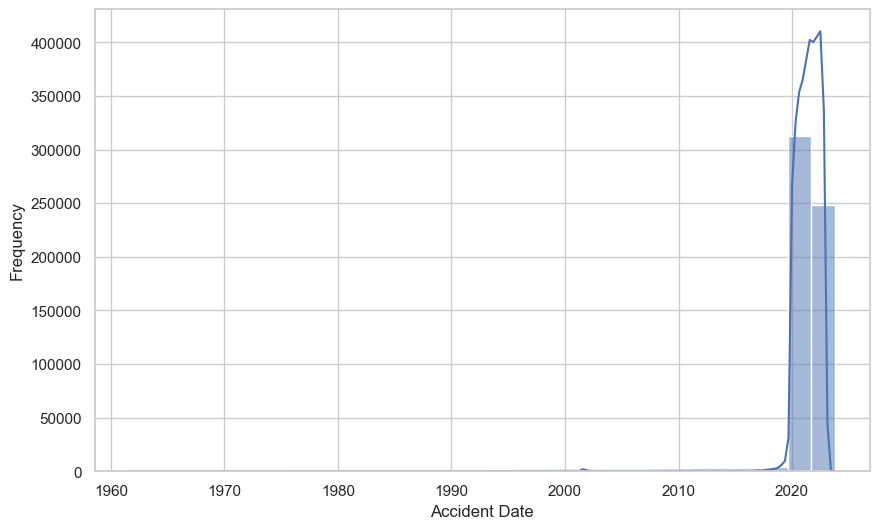

In [210]:
plot_hist(df_train, 'Accident Date')

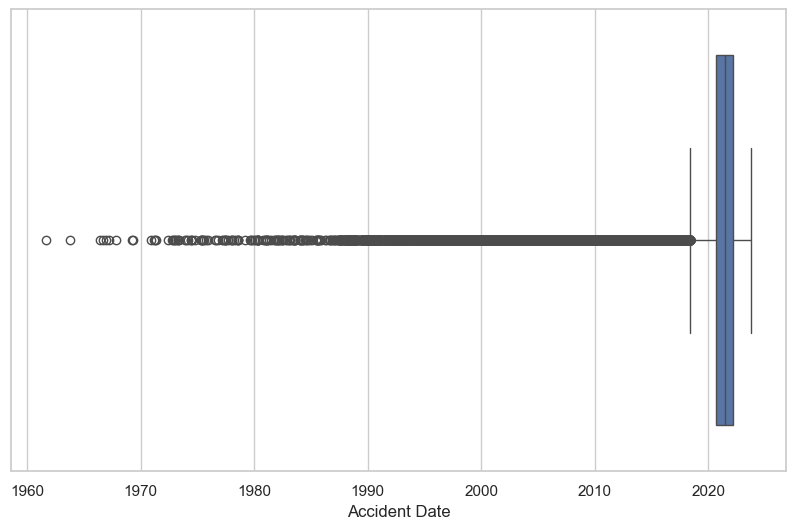

In [211]:
plot_box(df_train, 'Accident Date')

We can see by the histogram, that this variable is very assimetric probably due to having a big number of outliers as we can see in the boxplot. To get better visualisations we will omit this outliers in some visualisations

Now we will analyze the situation regarding the missing values:

In [212]:
print('The Accident Date variable has ' + str(df_train['Accident Date'].isna().mean()*100) + '% of missing values')
print('The Accident Date variable has ' + str(df_test['Accident Date'].isna().mean()*100) + '% of missing values')

The Accident Date variable has 3.898084320885098% of missing values
The Accident Date variable has 0.6299374959726787% of missing values


In [213]:
detect_outliers_in_column(df_train, 'Accident Date')['Accident Date'].max()

Timestamp('2018-06-07 00:00:00')

Let`s extract some adicional date-related columns

In [214]:
df_accident_time = df_train.copy()

In [215]:
df_accident_time['Accident Year'] = df_accident_time['Accident Date'].dt.year
df_accident_time['Accident Month'] = df_accident_time['Accident Date'].dt.month
df_accident_time['Accident DayOfWeek'] = df_accident_time['Accident Date'].dt.dayofweek

This next bar plot show us the number of accidents by day of th week:

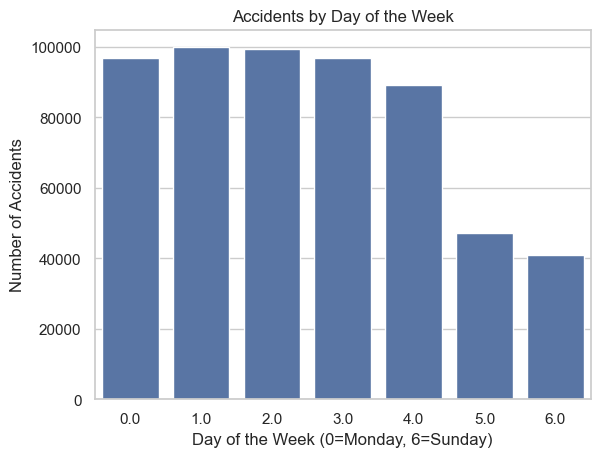

In [216]:
dayofweek_accidents = df_accident_time['Accident DayOfWeek'].value_counts().sort_index()
sns.barplot(x=dayofweek_accidents.index, y=dayofweek_accidents.values)
plt.title("Accidents by Day of the Week")
plt.xlabel("Day of the Week (0=Monday, 6=Sunday)")
plt.ylabel("Number of Accidents")
plt.show()

This plot shows that workplace accidents occur more frequently during weekdays, likely because most people work Monday through Friday, resulting in fewer incidents over the weekend when fewer people are on-site

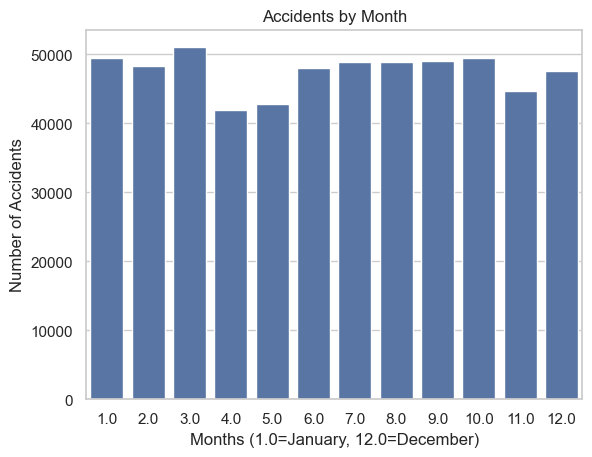

In [217]:
dayofweek_accidents = df_accident_time['Accident Month'].value_counts().sort_index()
sns.barplot(x=dayofweek_accidents.index, y=dayofweek_accidents.values)
plt.title("Accidents by Month")
plt.xlabel("Months (1.0=January, 12.0=December)")
plt.ylabel("Number of Accidents")
plt.show()

From the graph, we notice a decrease in workplace accidents in April and May. What could explain this trend?

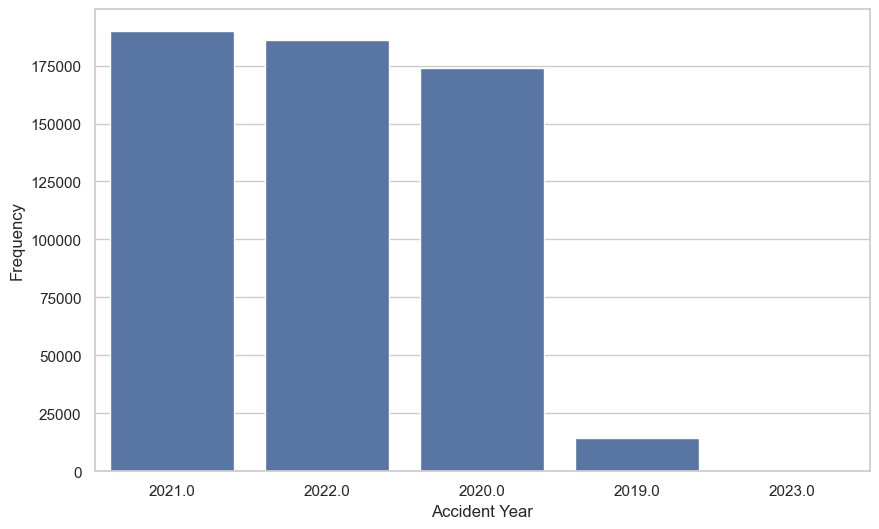

In [218]:
plot_bar(df_accident_time[df_accident_time['Accident Year']>2018], 'Accident Year')

- Observations
  - A lot of outliers (everything before mid 2018).
- Decisions
  - Split date into usable features during a later step.

### Assembly date variable

Let's examine the key statistics for this variable:

In [219]:
df_train['Assembly Date'].describe()

count                           593471
mean     2021-07-19 03:25:38.260841728
min                2020-01-01 00:00:00
25%                2020-10-26 00:00:00
50%                2021-07-29 00:00:00
75%                2022-04-19 00:00:00
max                2022-12-31 00:00:00
Name: Assembly Date, dtype: object

From this table, we see that the first assembly date in this dataframe occurred on 2020-01-01 and the last one on 2022-12-31.

In [220]:
print('The Assembly Date variable has ' + str(df_train['Assembly Date'].isna().mean()*100) + '% of missing values in the train data')
print('The Assembly Date variable has ' + str(df_test['Assembly Date'].isna().mean()*100) + '% of missing values in the test data')

The Assembly Date variable has 0.0% of missing values in the train data
The Assembly Date variable has 0.0% of missing values in the test data


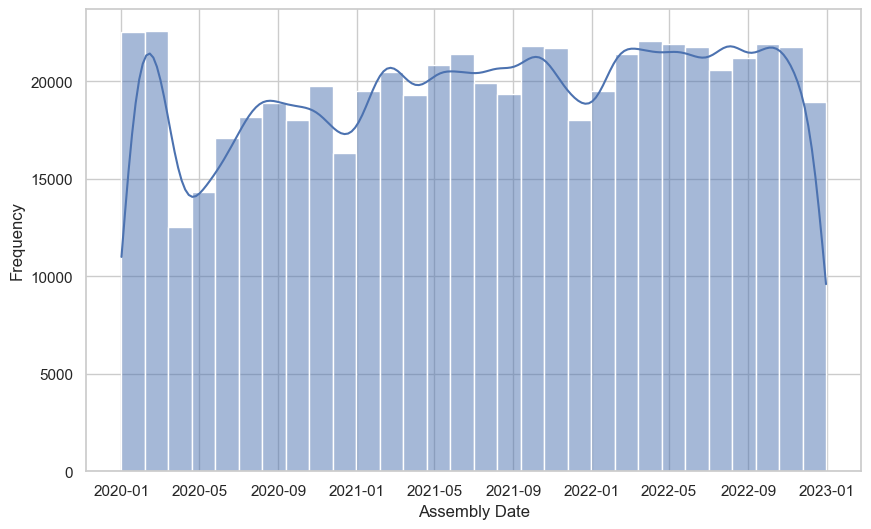

In [221]:
plot_hist(df_train, 'Assembly Date')

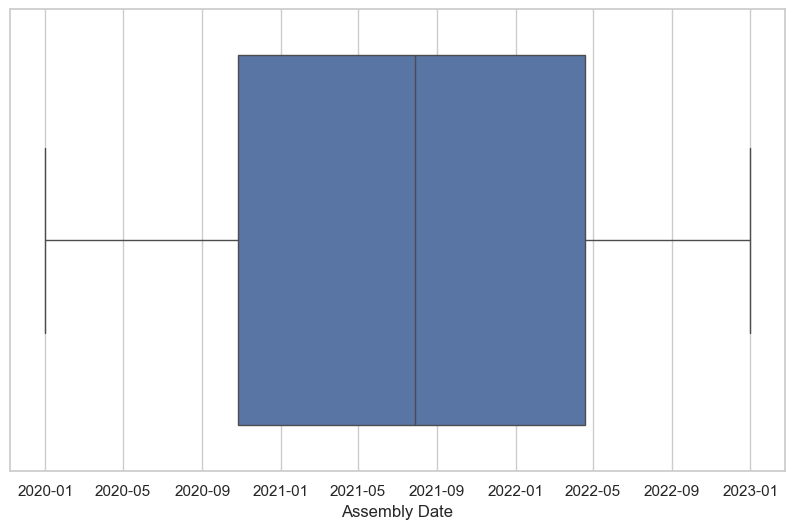

In [222]:
plot_box(df_train, 'Assembly Date')

- Observations
  - No outliers, evenly distributed.
- Decisions
  - Date will be extracted to time since accident date in a later step.

### C-2 Date variable

Let's examine the key statistics for this variable:

In [223]:
df_train['C-2 Date'].describe()

count                           559466
mean     2021-07-16 20:11:19.865443328
min                1996-01-12 00:00:00
25%                2020-11-06 00:00:00
50%                2021-08-09 00:00:00
75%                2022-04-26 00:00:00
max                2024-06-01 00:00:00
Name: C-2 Date, dtype: object

In [224]:
print('The C-2 Date variable has ' + str(df_train['C-2 Date'].isna().mean()*100) + '% of missing values in the train data')
print('The C-2 Date variable has ' + str(df_test['C-2 Date'].isna().mean()*100) + '% of missing values in the test data')

The C-2 Date variable has 5.729850321245689% of missing values in the train data
The C-2 Date variable has 2.3542754043430634% of missing values in the test data


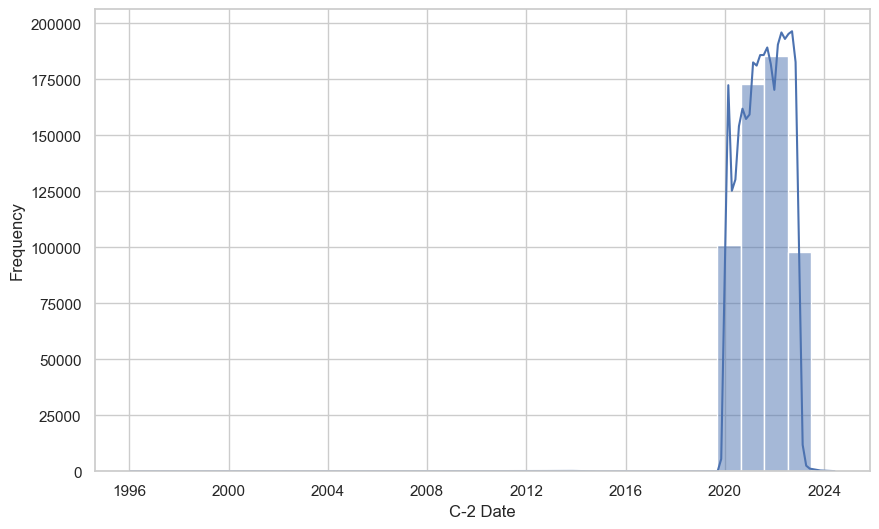

In [225]:
plot_hist(df_train, 'C-2 Date')

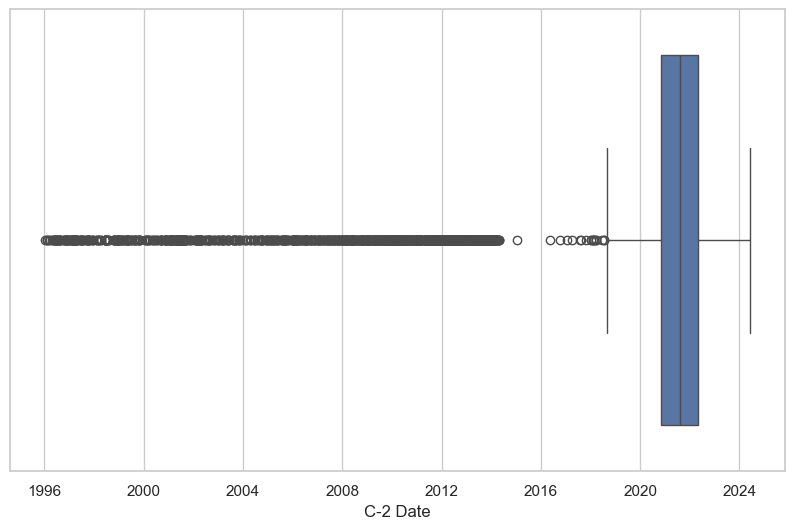

In [226]:
plot_box(df_train, 'C-2 Date')

- Observations
  - Lots of (evenly distributed) outliers.
- Decisions
  - Outliers won't be treated as they seem contain information due to the volume of outliers.

### C-3 Date variable

Let's examine the key statistics for this variable:

In [227]:
df_train['C-3 Date'].describe()

count                           187245
mean     2021-07-26 21:31:28.449891840
min                1992-11-13 00:00:00
25%                2020-10-27 00:00:00
50%                2021-07-21 00:00:00
75%                2022-04-20 00:00:00
max                2024-05-31 00:00:00
Name: C-3 Date, dtype: object

In [228]:
print('The C-3 Date variable has ' + str(df_train['C-3 Date'].isna().mean()*100) + '% of missing values in the train data')
print('The C-3 Date variable has ' + str(df_test['C-3 Date'].isna().mean()*100) + '% of missing values in the test data')

The C-3 Date variable has 68.4491744331231% of missing values in the train data
The C-3 Date variable has 78.0356981764289% of missing values in the test data


This variable is highly composed of missing values, so we will probably exclude her

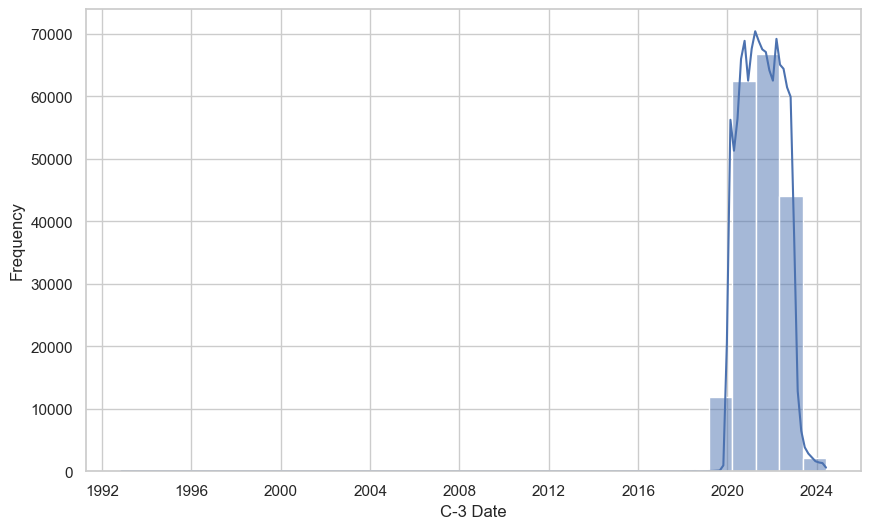

In [229]:
plot_hist(df_train, 'C-3 Date')

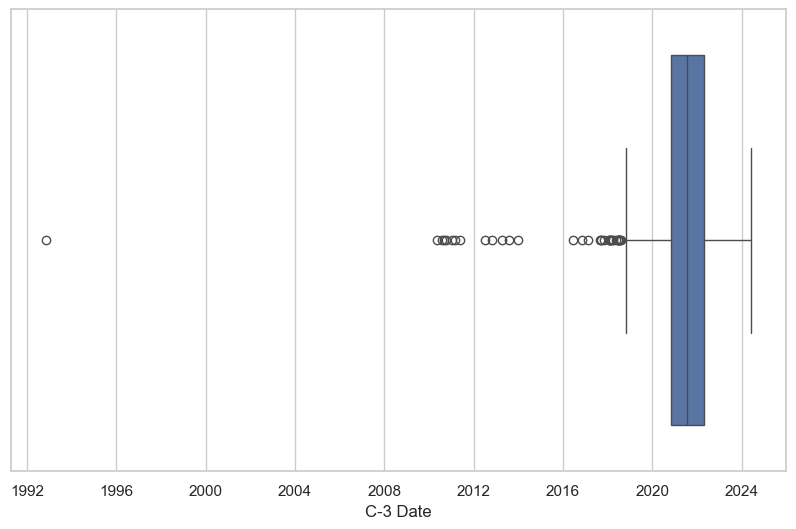

In [230]:
plot_box(df_train, 'C-3 Date')

In [231]:
lower_bound = pd.to_datetime('2018-01-01 00:00:00')
upper_bound = pd.to_datetime('2025-01-01 00:00:00')

df_train['C-3 Date'] = df_train['C-3 Date'].apply(lambda x: min(max(x, lower_bound), upper_bound))

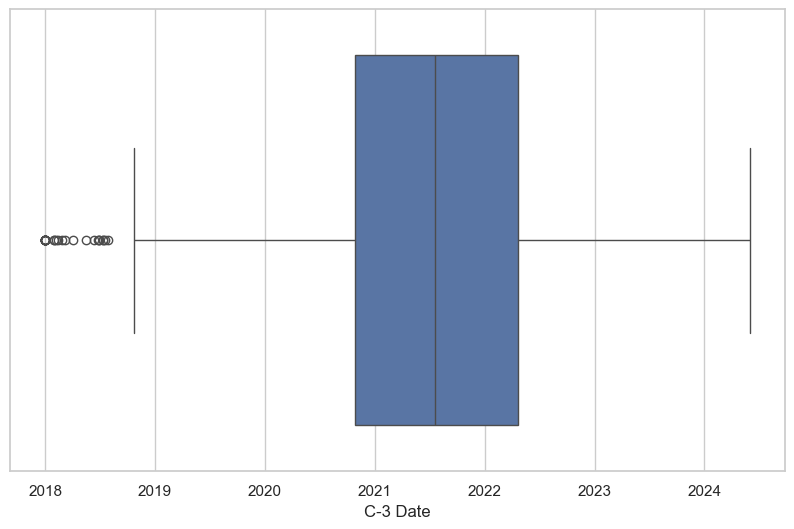

In [232]:
plot_box(df_train, 'C-3 Date')

- Observations
  - Some outliers, one extreme outlier.
- Decisions
  - Remove extreme outlier (anything before 01.01.2008).

### First Hearing Date variable

Let's examine the key statistics for this variable:

In [233]:
df_train['First Hearing Date'].describe()

count                           150798
mean     2022-03-19 05:07:38.218278400
min                2020-01-30 00:00:00
25%                2021-06-01 00:00:00
50%                2022-03-09 00:00:00
75%                2023-01-11 00:00:00
max                2024-06-07 00:00:00
Name: First Hearing Date, dtype: object

In [234]:
print('The First Hearing Date variable has ' + str(df_train['First Hearing Date'].isna().mean()*100) + '% of missing values in the train data')
print('The First Hearing Date has ' + str(df_test['First Hearing Date'].isna().mean()*100) + '% of missing values in the test data')

The First Hearing Date variable has 74.59050231603565% of missing values in the train data
The First Hearing Date has 88.90959469037954% of missing values in the test data


This variable is highly composed of missing values, so we will probably exclude her

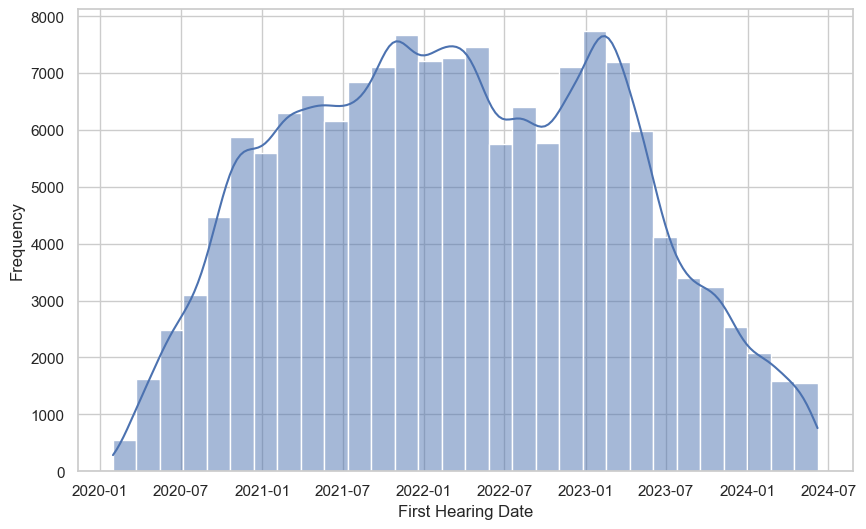

In [235]:
plot_hist(df_train, 'First Hearing Date')

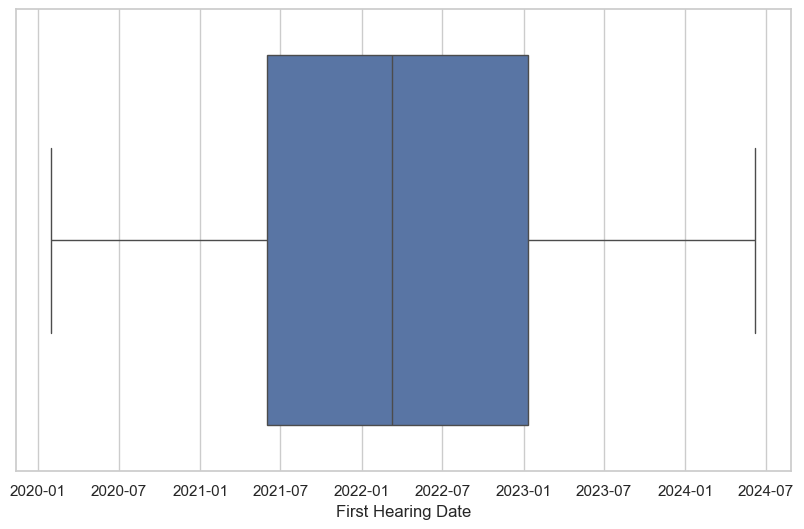

In [236]:
plot_box(df_train, 'First Hearing Date')

- Observations
  - High amount of missing values that will be treated by the imputer.
- Decisions
  - None

### Age at injury variable

Let's examine the key statistics for this variable:

In [237]:
df_train['Age at Injury'].describe()

count    574026.000000
mean         42.114270
std          14.256432
min           0.000000
25%          31.000000
50%          42.000000
75%          54.000000
max         117.000000
Name: Age at Injury, dtype: float64

In [238]:
print('The Age at Injury variable has ' + str(df_train['Age at Injury'].isna().mean()*100) + '% of missing values in the train data')
print('The Age at Injury variable has ' + str(df_test['Age at Injury'].isna().mean()*100) + '% of missing values in the test data')

The Age at Injury variable has 3.276486972404717% of missing values in the train data
The Age at Injury variable has 0.0% of missing values in the test data


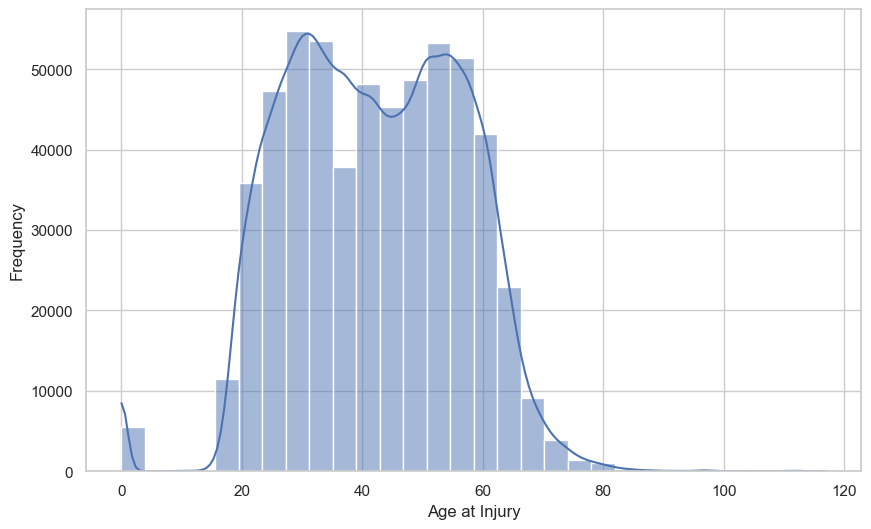

In [239]:
plot_hist(df_train, 'Age at Injury')

In [240]:
print(df_train[df_train['Age at Injury']==0]['Age at Injury'].count())
print(df_test[df_test['Age at Injury']==0]['Age at Injury'].count())

5464
3248


There is in this variable at the two dataframes null values, we will fill them with NAN values because they are probably due to some data coleting problem.

Another issue is the presence of incorrect values in this variable. Specifically, ages below 14 are invalid, as the minimum working age in the U.S. is 14 years. Additionally, ages exceeding 80 are also considered erroneous.

In [241]:
print(df_train[(df_train['Age at Injury'] < 14) | (df_train['Age at Injury'] > 80)]['Age at Injury'].count())
print(df_test[(df_test['Age at Injury'] < 14) | (df_test['Age at Injury'] > 80)]['Age at Injury'].count())

6302
4148


As there is a small number of rows with this problem, we will just eliminate them (only in train data)

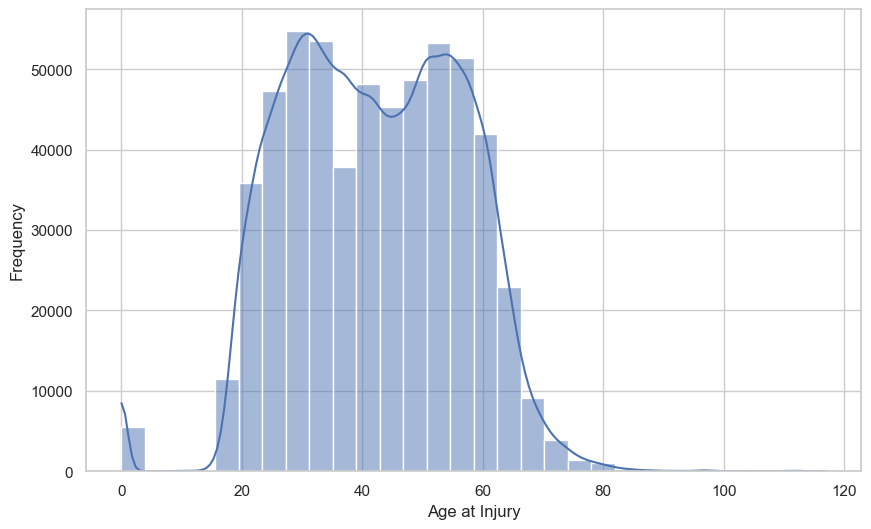

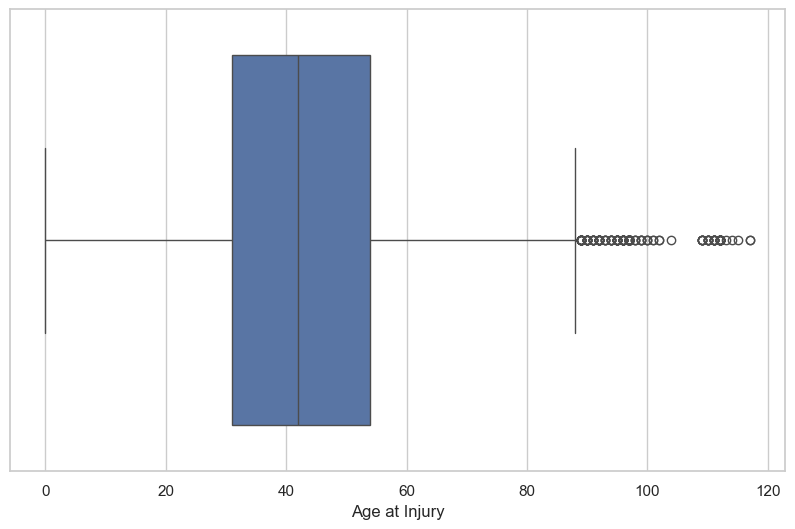

In [242]:
plot_hist(df_train, 'Age at Injury')
plot_box(df_train, 'Age at Injury')

- Observations
  - No outliers.
  - Lots of 0 values
  - Ages below 14 or above 80 exist.
- Decisions
  - We want to replace 0 with NaN for them to be imputed
  - We regard ages below 14 or above 80 as erroneous, therefore dropping any rows where this is the case from the training data. We consider the probability of these rows being full with false data high, therefore our model should not be trained on those.

### Birth Year variable

Let's examine the key statistics for this variable:

In [243]:
df_train['Birth Year'].describe()

count    544948.000000
mean       1886.767604
std         414.644423
min           0.000000
25%        1965.000000
50%        1977.000000
75%        1989.000000
max        2018.000000
Name: Birth Year, dtype: float64

There are Birth years with a value of 0, this is clearly an error so we will replace it with a missing value

In [244]:
df_train[df_train['Birth Year']==0]['Birth Year'].count()

25081

In [245]:
print('The Birth Year variable has ' + str(df_train['Birth Year'].isna().mean()*100) + '% of missing values in the train data')
print('The Birth Year variable has ' + str(df_test['Birth Year'].isna().mean()*100) + '% of missing values in the test data')

The Birth Year variable has 8.176136660426542% of missing values in the train data
The Birth Year variable has 5.018364585346994% of missing values in the test data


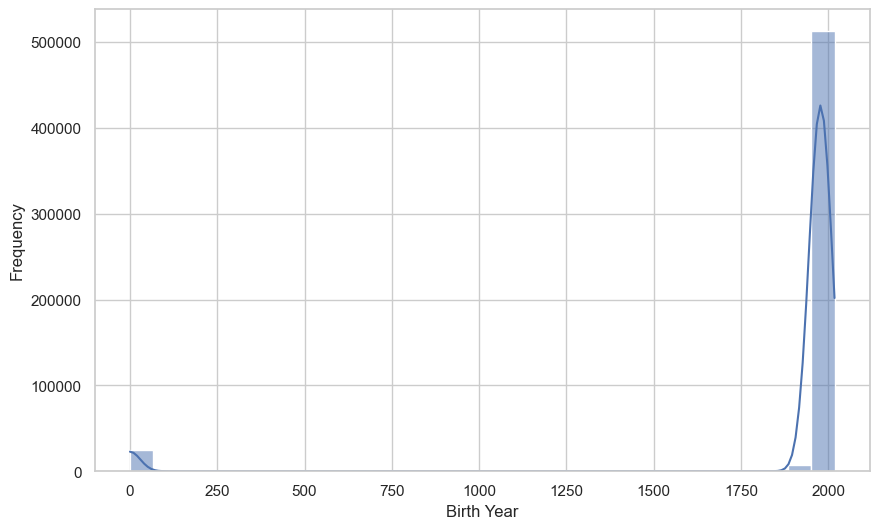

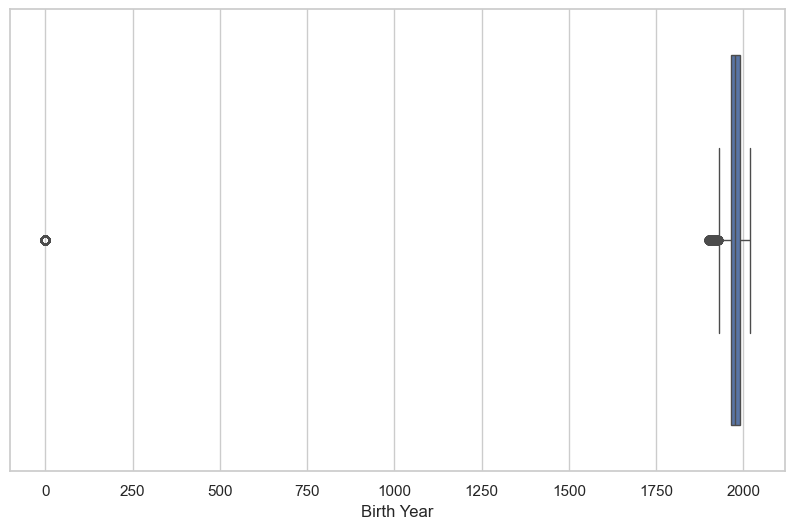

In [246]:
plot_hist(df_train, 'Birth Year')
plot_box(df_train, 'Birth Year')


- Observations
  - Some outliers, not extreme.
- Decisions
  - Replace 0 with NaN



### Carrier Type variable

Let's examine the key statistics for this variable:

In [247]:
df_train['Carrier Type'].describe()

count          574026
unique              8
top       1A. PRIVATE
freq           285368
Name: Carrier Type, dtype: object

In [248]:
df_train['Carrier Type'].value_counts()

Carrier Type
1A. PRIVATE                                    285368
3A. SELF PUBLIC                                121920
2A. SIF                                        111144
4A. SELF PRIVATE                                52788
UNKNOWN                                          1774
5D. SPECIAL FUND - UNKNOWN                       1023
5C. SPECIAL FUND - POI CARRIER WCB MENANDS          5
5A. SPECIAL FUND - CONS. COMM. (SECT. 25-A)         4
Name: count, dtype: int64

In [249]:
print('The Carrier Type variable has ' + str(df_train['Carrier Type'].isna().mean()*100) + '% of missing values in the train data')
print('The Carrier Type variable has ' + str(df_test['Carrier Type'].isna().mean()*100) + '% of missing values in the test data')

The Carrier Type variable has 3.276486972404717% of missing values in the train data
The Carrier Type variable has 0.0% of missing values in the test data


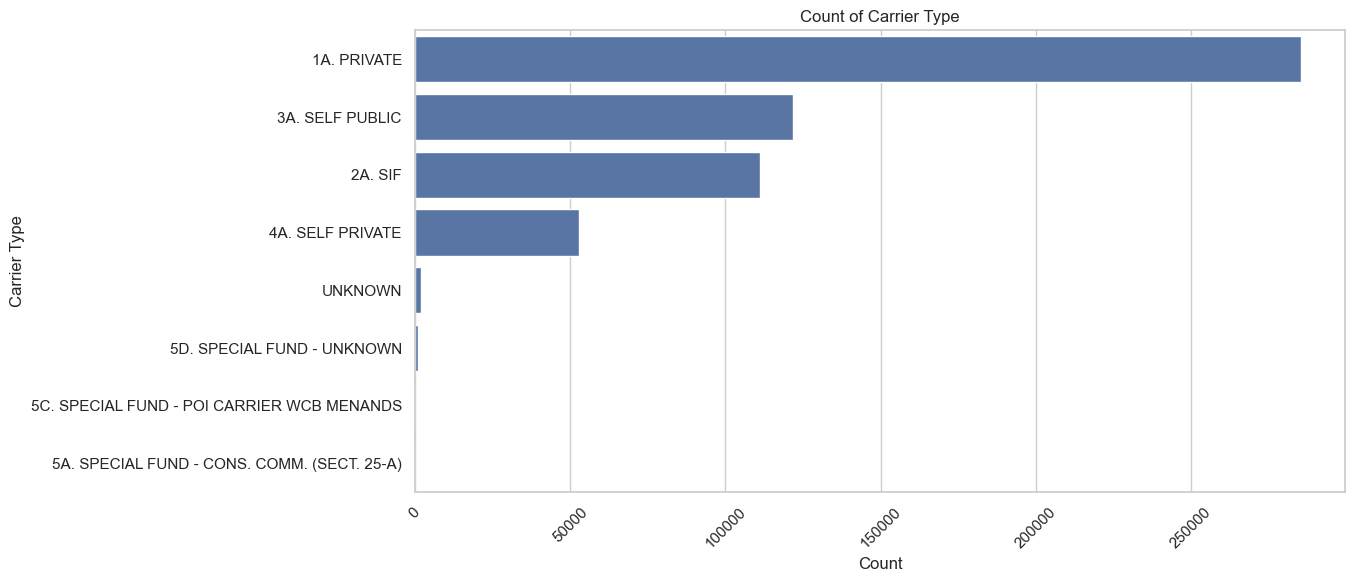

In [250]:
# Set the style for the plots
sns.set(style="whitegrid")

# Create a count plot for 'District Name'
plt.figure(figsize=(12, 6))
sns.countplot(data=df_train, y='Carrier Type', order=df_train['Carrier Type'].value_counts().index)
plt.title('Count of Carrier Type')
plt.xlabel('Count')
plt.ylabel('Carrier Type')
plt.xticks(rotation=45)  # Rotate x labels if needed
plt.show()

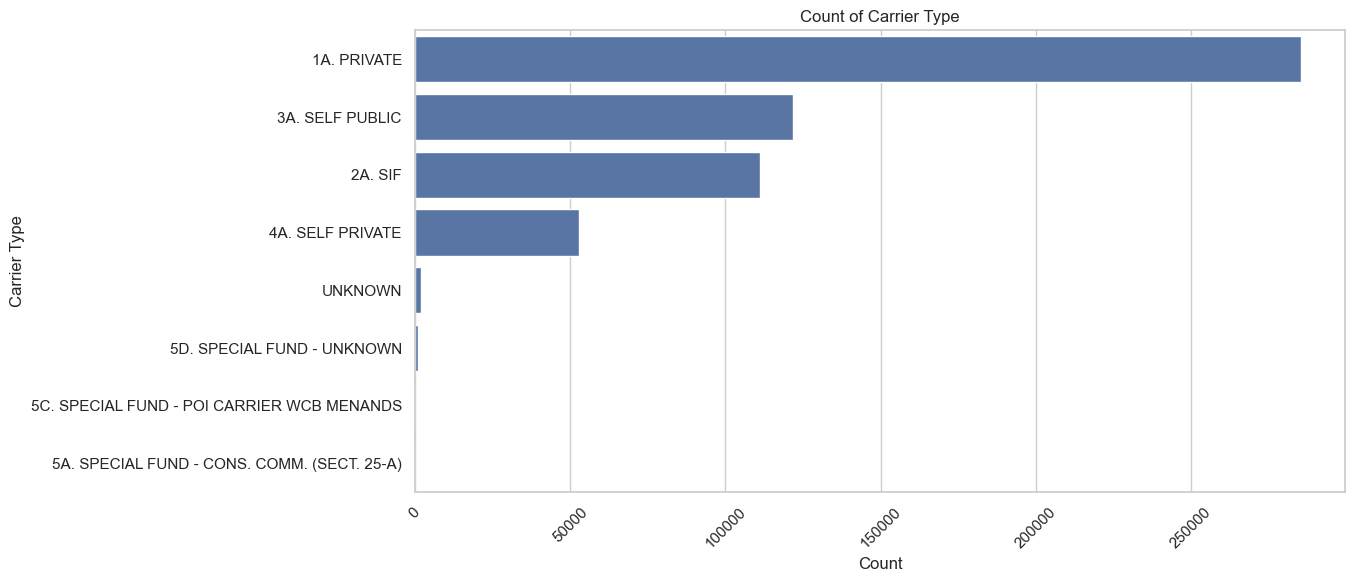

In [251]:
# Set the style for the plots
sns.set(style="whitegrid")

# Create a count plot for 'District Name'
plt.figure(figsize=(12, 6))
sns.countplot(data=df_train, y='Carrier Type', order=df_train['Carrier Type'].value_counts().index)
plt.title('Count of Carrier Type')
plt.xlabel('Count')
plt.ylabel('Carrier Type')
plt.xticks(rotation=45)  # Rotate x labels if needed
plt.show()

- Observations
  -
- Decisions
  - Replace unknown with NaN

### County of Injury variable

Let's examine the key statistics for this variable:

In [252]:
df_train['County of Injury'].describe()

count      574026
unique         63
top       SUFFOLK
freq        60430
Name: County of Injury, dtype: object

In [253]:
df_train['County of Injury'].unique()

array(['ST. LAWRENCE', 'WYOMING', 'ORANGE', nan, 'DUTCHESS', 'SUFFOLK',
       'ONONDAGA', 'RICHMOND', 'MONROE', 'KINGS', 'NEW YORK', 'QUEENS',
       'WESTCHESTER', 'GREENE', 'NASSAU', 'ALBANY', 'ERIE', 'BRONX',
       'CAYUGA', 'NIAGARA', 'LIVINGSTON', 'WASHINGTON', 'MADISON',
       'WARREN', 'SENECA', 'GENESEE', 'SARATOGA', 'CHAUTAUQUA',
       'COLUMBIA', 'RENSSELAER', 'CATTARAUGUS', 'ROCKLAND', 'SCHUYLER',
       'BROOME', 'ULSTER', 'CLINTON', 'ONEIDA', 'UNKNOWN', 'MONTGOMERY',
       'ONTARIO', 'SCHENECTADY', 'CHEMUNG', 'YATES', 'HERKIMER',
       'ALLEGANY', 'TIOGA', 'FULTON', 'DELAWARE', 'TOMPKINS', 'PUTNAM',
       'OSWEGO', 'LEWIS', 'ESSEX', 'OTSEGO', 'CORTLAND', 'ORLEANS',
       'SULLIVAN', 'CHENANGO', 'FRANKLIN', 'WAYNE', 'JEFFERSON',
       'STEUBEN', 'SCHOHARIE', 'HAMILTON'], dtype=object)

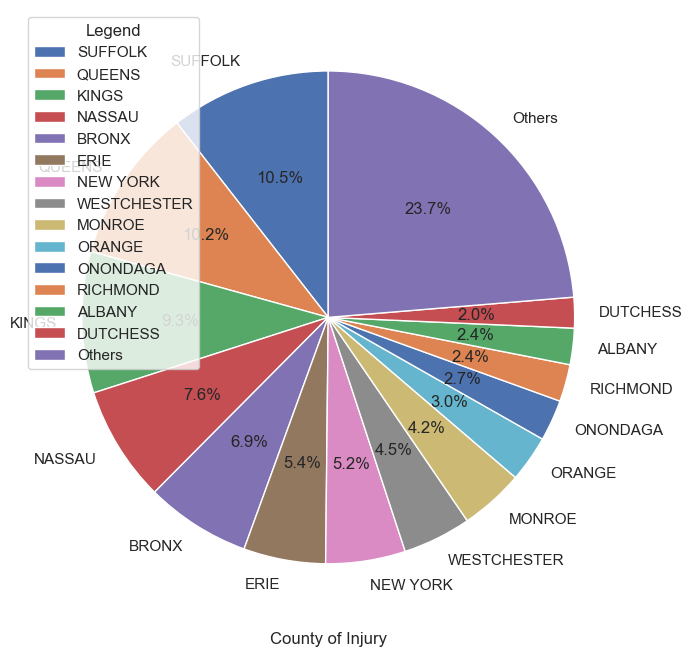

In [254]:
plot_pie(df_train, 'County of Injury')

In [255]:
print('The County of Injury variable has ' + str(df_train['County of Injury'].isna().mean()*100) + '% of missing values in the train data')
print('The County of Injury variable has ' + str(df_test['County of Injury'].isna().mean()*100) + '% of missing values in the test data')

The County of Injury variable has 3.276486972404717% of missing values in the train data
The County of Injury variable has 0.0% of missing values in the test data


- Observations
  - No unknown/others
- Decisions
  - No actions

### Attorney Representation variable

Let's examine the key statistics for this variable:

In [256]:
df_train['Attorney/Representative'].describe()

count     574026
unique         2
top            N
freq      392291
Name: Attorney/Representative, dtype: object

In [257]:
df_train['Attorney/Representative'].value_counts()

Attorney/Representative
N    392291
Y    181735
Name: count, dtype: int64

In [258]:
print('The Attorney/Representative variable has ' + str(df_train['Attorney/Representative'].isna().mean()*100) + '% of missing values in the train data')
print('The Attorney/Representative variable has ' + str(df_test['Attorney/Representative'].isna().mean()*100) + '% of missing values in the test data')

The Attorney/Representative variable has 3.276486972404717% of missing values in the train data
The Attorney/Representative variable has 0.0% of missing values in the test data


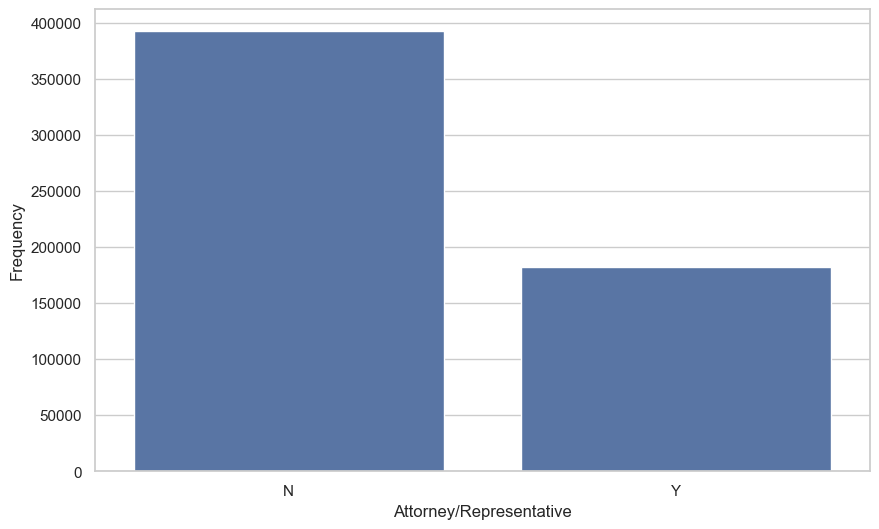

In [259]:
plot_bar(df_train, 'Attorney/Representative')

- Observations
  - No unknown labels
- Decisions
  - Change feature type to boolean

### Alternative Dispute Resolution variable

Let's examine the key statistics for this variable:

In [260]:
df_train['Alternative Dispute Resolution'].describe()

count     574026
unique         3
top            N
freq      571412
Name: Alternative Dispute Resolution, dtype: object

In [261]:
print('The Alternative Dispute Resolution variable has ' + str(df_train['Alternative Dispute Resolution'].isna().mean()*100) + '% of missing values in the train data')
print('The Alternative Dispute Resolution variable has ' + str(df_test['Alternative Dispute Resolution'].isna().mean()*100) + '% of missing values in the test data')

The Alternative Dispute Resolution variable has 3.276486972404717% of missing values in the train data
The Alternative Dispute Resolution variable has 0.0% of missing values in the test data


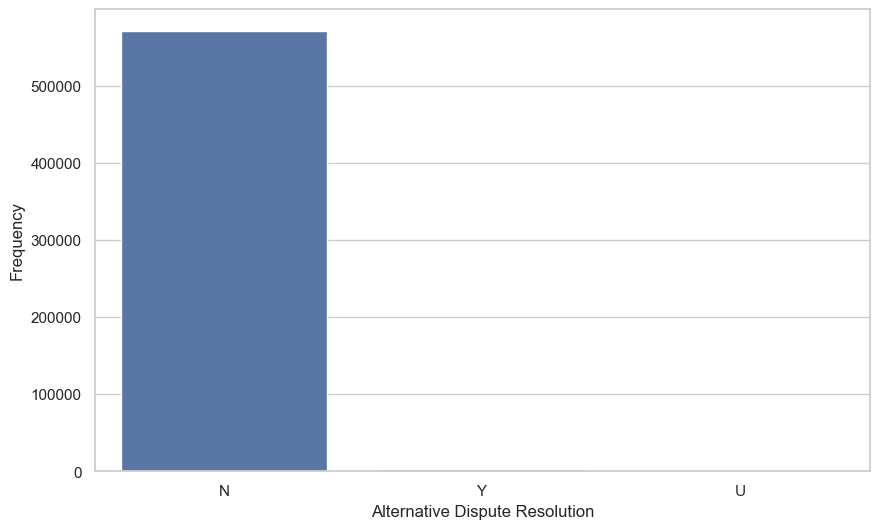

In [262]:
plot_bar(df_train, 'Alternative Dispute Resolution')

- Observations
  - Very asymetric - most are False
  - Unknown label "U"
- Decisions
  - Unknown label "U" to NaN

### Carrier Name variable

Let's examine the key statistics for this variable:

In [263]:
df_train['Carrier Name'].describe()

count                   574026
unique                    2046
top       STATE INSURANCE FUND
freq                    111144
Name: Carrier Name, dtype: object

In [264]:
print('The Carrier Name variable has ' + str(df_train['Carrier Name'].isna().mean()*100) + '% of missing values in the train data')
print('The Carrier Name variable has ' + str(df_test['Carrier Name'].isna().mean()*100) + '% of missing values in the test data')

The Carrier Name variable has 3.276486972404717% of missing values in the train data
The Carrier Name variable has 0.0% of missing values in the test data


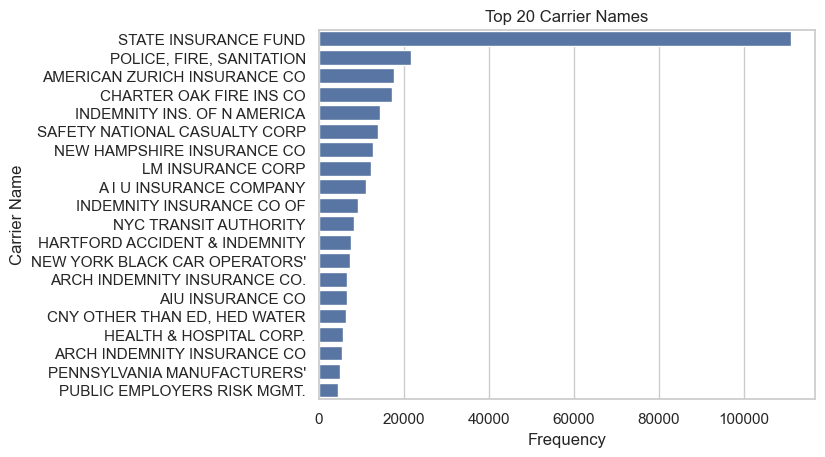

In [265]:
top_carriers = df_train['Carrier Name'].value_counts().nlargest(20)
sns.barplot(x=top_carriers.values, y=top_carriers.index)
plt.title('Top 20 Carrier Names')
plt.xlabel('Frequency')
plt.ylabel('Carrier Name')
plt.show()

In [266]:
df_train['Carrier Name'].unique().shape

(2047,)

In [267]:
df_train['Carrier Name'][df_train['Carrier Name'].str.contains("unknown", case=False, na=False)].unique()

array([], dtype=object)

- Observations
  - A lot of labels (2000+)
  - No unknown labels
- Decisions
  - TODO: Replace unknown carriers with "OTHERS"?

### Claim Identifier variable

Let's examine the key statistics for this variable:

In [268]:
df_train['Claim Identifier'].describe()

count    5.934710e+05
mean     2.366760e+07
std      1.079271e+08
min      5.393066e+06
25%      5.593414e+06
50%      5.791212e+06
75%      5.991000e+06
max      9.998917e+08
Name: Claim Identifier, dtype: float64

In [269]:
df_train['Claim Identifier'].nunique()

593470

In [270]:
df_train['Claim Identifier'].size

593471

In [271]:
print('The Claim Identifier variable has ' + str(df_train['Claim Identifier'].isna().mean()*100) + '% of missing values in the train data')
print('The Claim Identifier variable has ' + str(df_test['Claim Identifier'].isna().mean()*100) + '% of missing values in the test data')

The Claim Identifier variable has 0.0% of missing values in the train data
The Claim Identifier variable has 0.0% of missing values in the test data


In [272]:
# Check duplicate rows
df_train[df_train['Claim Identifier'].duplicated(keep=False)]

,Accident Date,Age at Injury,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,...,WCIO Cause of Injury Code,WCIO Cause of Injury Description,WCIO Nature of Injury Code,WCIO Nature of Injury Description,WCIO Part Of Body Code,WCIO Part Of Body Description,Zip Code,Agreement Reached,WCB Decision,Number of Dependents
257901,NaT,NaN,NaN,2021-05-21,NaN,NaN,NaN,NaT,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
526445,NaT,NaN,NaN,2022-09-05,NaN,NaN,NaN,NaT,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- Observations
  - One duplicate identifier. Both Rows are full of NaN values upon closer inspection.
- Decisions
  - Remove all rows of this Identifier as they seem to be erroneous.

### District Name variable

In [273]:
df_train['District Name'] = df_train['District Name'].astype('category')
df_test['District Name'] = df_test['District Name'].astype('category')

Let's examine the key statistics for this variable:

In [274]:
df_train['District Name'].describe()

count     574026
unique         8
top          NYC
freq      270779
Name: District Name, dtype: object

In [275]:
print('The District Name variable has ' + str(df_train['District Name'].isna().mean()*100) + '% of missing values in the train data')
print('The District Name variable has ' + str(df_test['District Name'].isna().mean()*100) + '% of missing values in the test data')

The District Name variable has 3.276486972404717% of missing values in the train data
The District Name variable has 0.0% of missing values in the test data


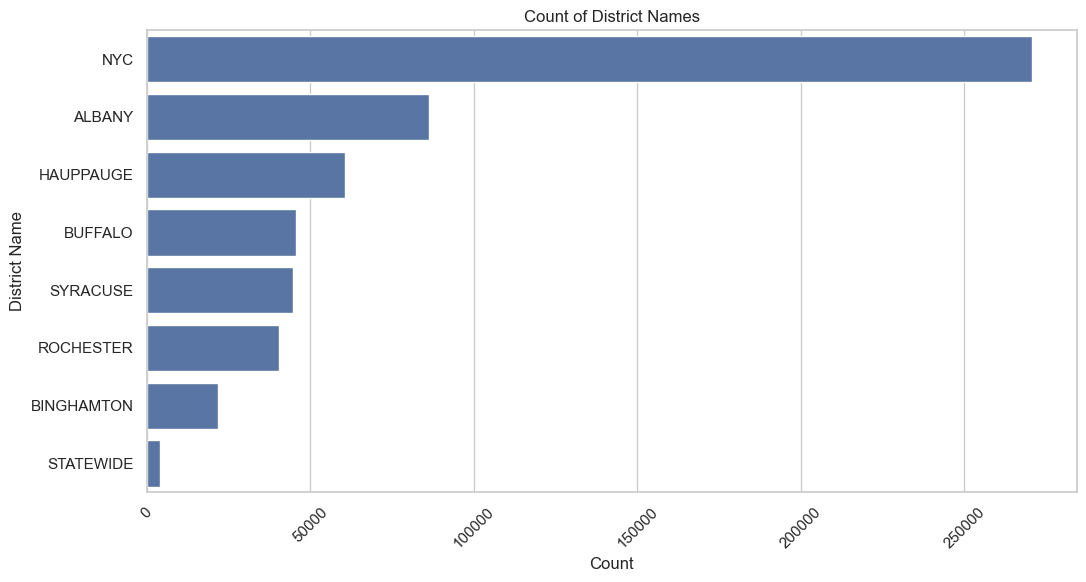

In [276]:
# Set the style for the plots
sns.set(style="whitegrid")

# Create a count plot for 'District Name'
plt.figure(figsize=(12, 6))
sns.countplot(data=df_train, y='District Name', order=df_train['District Name'].value_counts().index)
plt.title('Count of District Names')
plt.xlabel('Count')
plt.ylabel('District Name')
plt.xticks(rotation=45)  # Rotate x labels if needed
plt.show()

- Observations
  - No unknown values
- Decisions
  - None

### IME-4 Count variable

Let's examine the key statistics for this variable:

In [277]:
df_train['IME-4 Count'].describe()

count    132803.000000
mean          3.207337
std           2.832303
min           1.000000
25%           1.000000
50%           2.000000
75%           4.000000
max          73.000000
Name: IME-4 Count, dtype: float64

In [278]:
print('The IME-4 Count variable has ' + str(df_train['IME-4 Count'].isna().mean()*100) + '% of missing values in the train data')
print('The IME-4 Count variable has ' + str(df_test['IME-4 Count'].isna().mean()*100) + '% of missing values in the test data')

The IME-4 Count variable has 77.6226639549363% of missing values in the train data
The IME-4 Count variable has 90.91462078742187% of missing values in the test data


Number of IME-4 forms received per claim. The IME-4 form is the “Independent Examiner's Report of Independent Medical Examination” form.

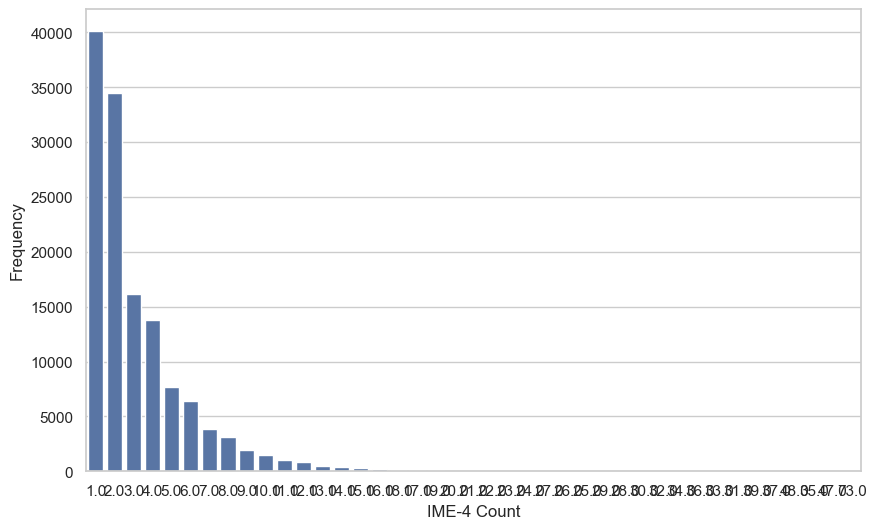

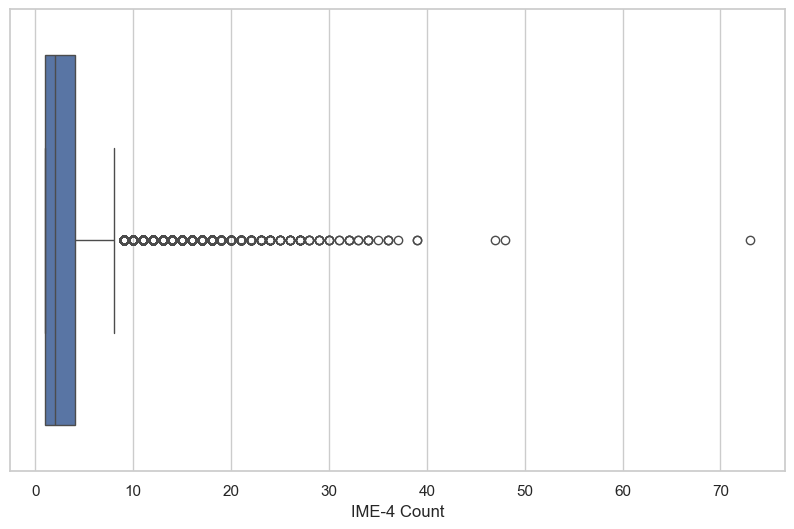

In [279]:
plot_bar(df_train, 'IME-4 Count')
plot_box(df_train, 'IME-4 Count')

Having more than 10 filled IME-4 forms per claim does raise some concerns and could indicate potential errors or unusual circumstances.

In [280]:
df_train[df_train['IME-4 Count'] > 10]['IME-4 Count'].count()

3794

In [281]:
high_submission_claims = df_train[df_train['IME-4 Count'] > 10]
high_submission_claims.head()

,Accident Date,Age at Injury,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,...,WCIO Cause of Injury Code,WCIO Cause of Injury Description,WCIO Nature of Injury Code,WCIO Nature of Injury Description,WCIO Part Of Body Code,WCIO Part Of Body Description,Zip Code,Agreement Reached,WCB Decision,Number of Dependents
269,2019-12-22,22.0,N,2020-01-02,Y,443.40,1997.0,2020-01-02,NaT,AMERICAN ZURICH INSURANCE CO,...,74.0,"FELLOW WORKER, PATIENT OR OTHER PERSON",16.0,DISLOCATION,53.0,KNEE,11210,1.0,Not Work Related,2.0
441,2019-12-10,49.0,N,2020-01-02,Y,909.39,1970.0,2020-05-29,2019-12-23,EVEREST NATIONAL INSURANCE CO.,...,45.0,COLLISION OR SIDESWIPE WITH ANOTHER VEHICLE,52.0,STRAIN OR TEAR,90.0,MULTIPLE BODY PARTS (INCLUDING BODY,11208,0.0,Not Work Related,1.0
452,2019-12-20,50.0,N,2020-01-02,Y,1383.50,0.0,2020-01-02,NaT,MANUFACTURERS ALLIANCE,...,56.0,LIFTING,52.0,STRAIN OR TEAR,42.0,LOWER BACK AREA,12419,1.0,Not Work Related,0.0
460,2019-12-31,56.0,N,2020-01-02,Y,900.20,1964.0,2020-01-02,NaT,STATE INSURANCE FUND,...,29.0,ON SAME LEVEL,28.0,FRACTURE,55.0,ANKLE,12458,0.0,Not Work Related,1.0
741,2019-12-20,39.0,N,2020-01-03,Y,756.78,1980.0,2020-01-03,2020-01-24,HARTFORD ACCIDENT & INDEMNITY,...,45.0,COLLISION OR SIDESWIPE WITH ANOTHER VEHICLE,52.0,STRAIN OR TEAR,42.0,LOWER BACK AREA,10460,0.0,Not Work Related,3.0


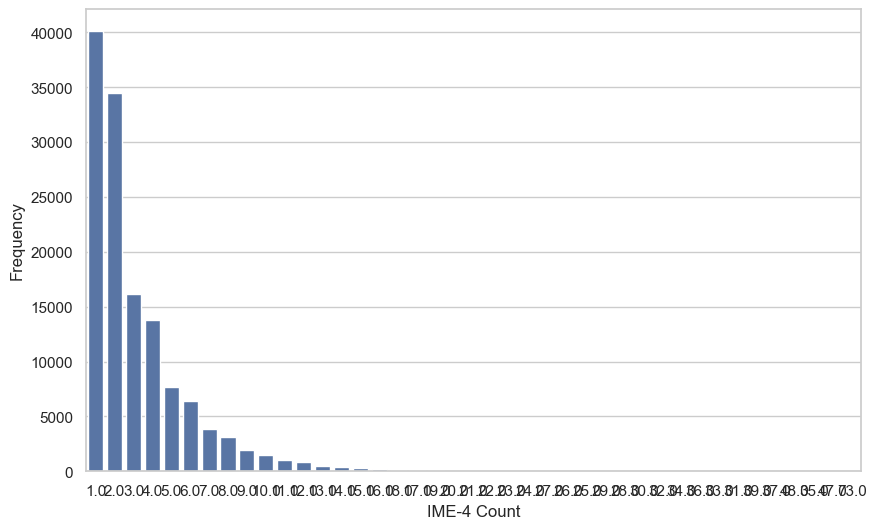

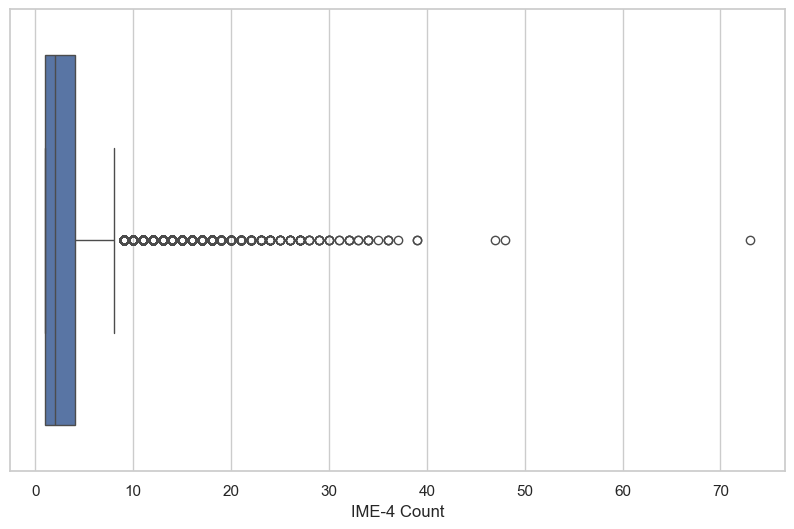

In [282]:
plot_bar(df_train, 'IME-4 Count')
plot_box(df_train, 'IME-4 Count')

- Observations
  - A lot of cases with more than 10 medical forms submitted.
- Decisions
  - Cap medical forms to 10. We consider anything from 10 to be extreme.

### Number of Dependents variable

Let's examine the key statistics for this variable:

In [283]:
df_train['Number of Dependents'].describe()

count    574026.000000
mean          3.006559
std           2.000801
min           0.000000
25%           1.000000
50%           3.000000
75%           5.000000
max           6.000000
Name: Number of Dependents, dtype: float64

In [284]:
print('The Number of Dependents variable has ' + str(df_train['Number of Dependents'].isna().mean()*100) + '% of missing values in the train data')
print('The Number of Dependents variable has ' + str(df_test['Number of Dependents'].isna().mean()*100) + '% of missing values in the test data')

The Number of Dependents variable has 3.276486972404717% of missing values in the train data
The Number of Dependents variable has 0.0% of missing values in the test data


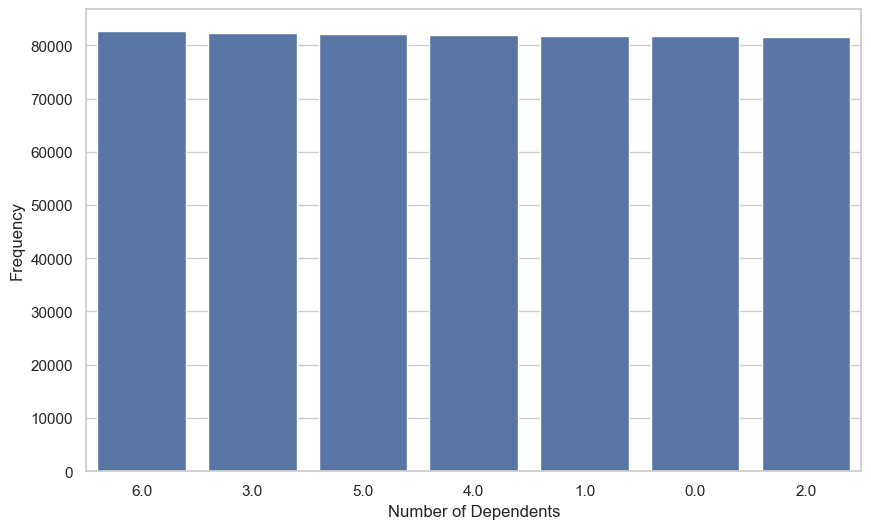

In [285]:
plot_bar(df_train, 'Number of Dependents')

### COVID-19 Indicator variable

Let's examine the key statistics for this variable:

In [286]:
df_train['COVID-19 Indicator'].describe()

count     574026
unique         2
top            N
freq      546505
Name: COVID-19 Indicator, dtype: object

In [287]:
df_train['COVID-19 Indicator'].value_counts()

COVID-19 Indicator
N    546505
Y     27521
Name: count, dtype: int64

In [288]:
print('The COVID-19 Indicator variable has ' + str(df_train['COVID-19 Indicator'].isna().mean()*100) + '% of missing values in the train data')
print('The COVID-19 Indicator variable has ' + str(df_test['COVID-19 Indicator'].isna().mean()*100) + '% of missing values in the test data')

The COVID-19 Indicator variable has 3.276486972404717% of missing values in the train data
The COVID-19 Indicator variable has 0.0% of missing values in the test data


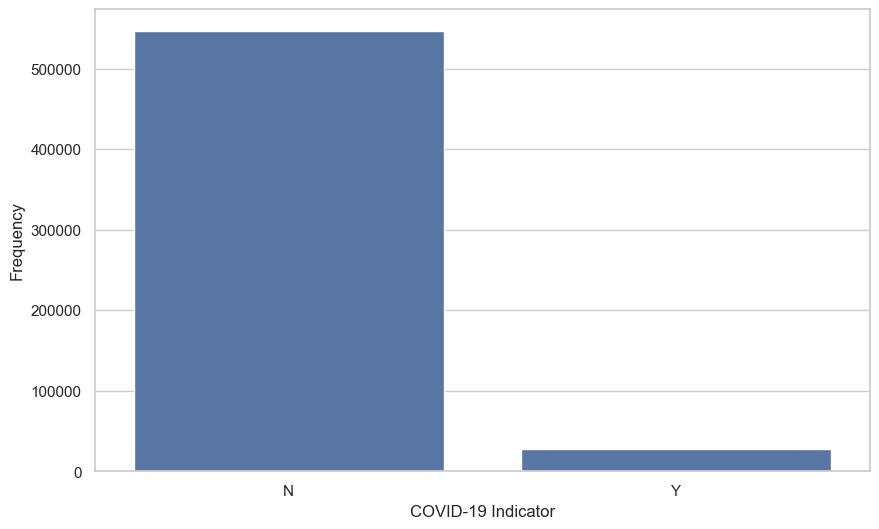

In [289]:
plot_bar(df_train, 'COVID-19 Indicator')

- Observations
  - No unknown values.
- Decisions
  - Transform to boolean

### Average Weekly Wage variable

Let's examine the key statistics for this variable:

In [290]:
df_train['Average Weekly Wage'].describe()

count    5.453750e+05
mean     4.910883e+02
std      6.092918e+03
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      8.410000e+02
max      2.828079e+06
Name: Average Weekly Wage, dtype: float64

In [291]:
(df_train['Average Weekly Wage'] == 0).sum()

335450

It is not possible to have values in 'Average Weekly Wage' recorded as zero since we are talking about workers. Since there are 333933 values recorded as zero, it is very unlikely that this is an error. We replace the zeros with NaN values.

In [292]:
df_train['Average Weekly Wage'] = df_train['Average Weekly Wage'].replace(0, np.nan)

In [293]:
(df_train['Average Weekly Wage'].isna().mean())*100


64.62758921665927

More than 60% of the Average Weekly Wage column has unknown information. This gonna produce issues in analysis and modeling. Replacing those missing values with statistical measures like the mean or median can skew results and introduce bias, especially if the data is not missing at random. Using methods like KNN can also lead to unreliable estimates if the underlying distribution is not well understood.


Given these circumstances, removing the column might be the most prudent approach.


Let's explore the variable anyway

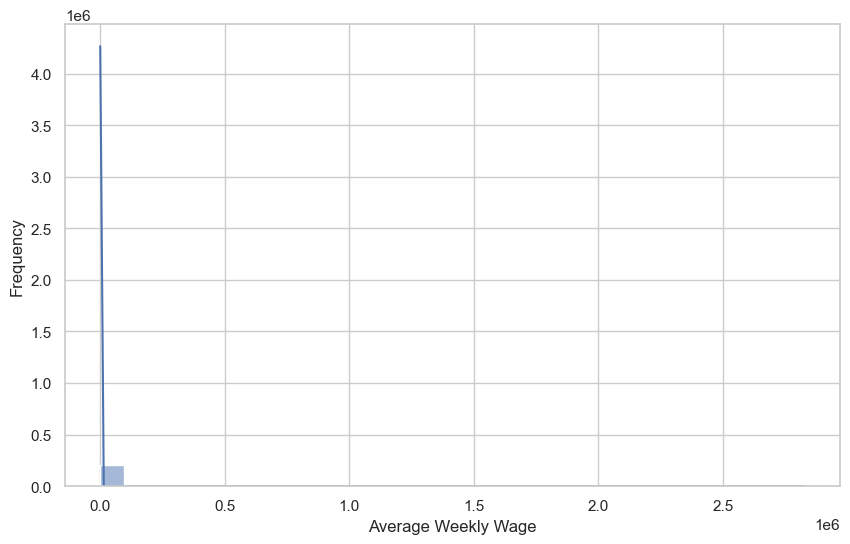

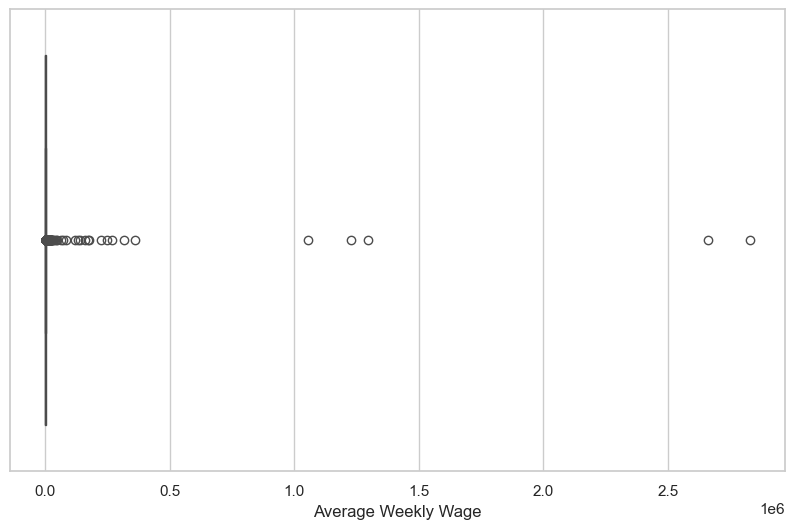

In [294]:
plot_hist(df_train, 'Average Weekly Wage')
plot_box(df_train, 'Average Weekly Wage')

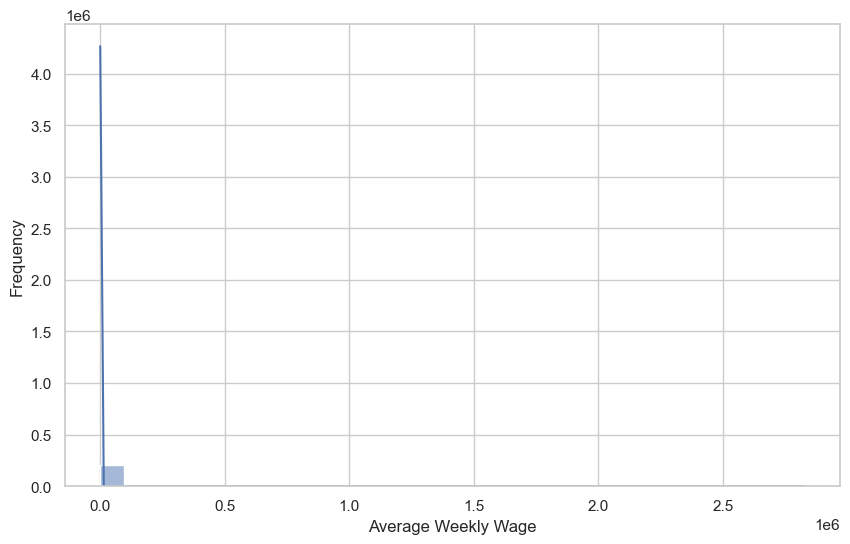

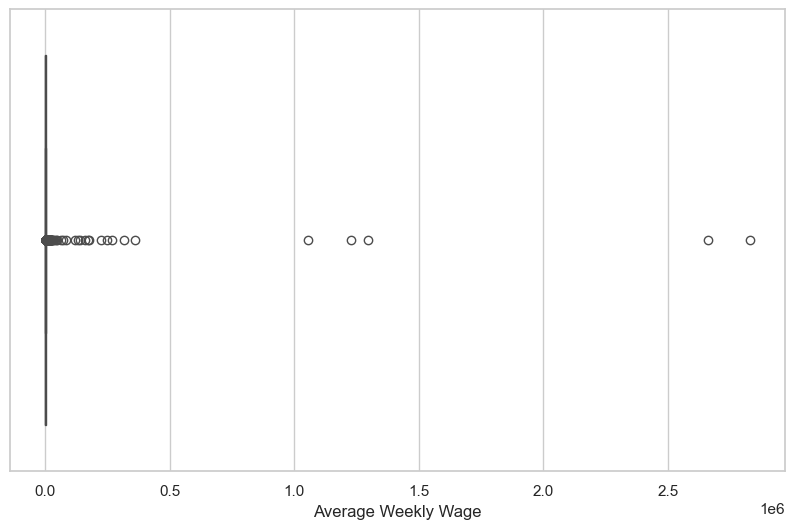

In [295]:
plot_hist(df_train, 'Average Weekly Wage')
plot_box(df_train, 'Average Weekly Wage')

- Observations
  - A lot of high outliers.
- Decisions
  - Cap extreme outliers (anything above 30k weekly income is counted as extreme).

### Industry code and Industry code description variable

Let's examine the key statistics for this variable:

In [296]:
df_train['Industry Code'].describe()

count     564068.0
unique        24.0
top           62.0
freq      114339.0
Name: Industry Code, dtype: float64

In [297]:
df_train['Industry Code'].value_counts()

Industry Code
62.0    114339
92.0     92240
61.0     44393
44.0     43685
48.0     37319
23.0     30903
72.0     26456
56.0     21027
45.0     17953
33.0     17232
49.0     16704
42.0     15236
81.0     13149
32.0     10804
31.0     10114
71.0      9967
54.0      9770
51.0      9166
53.0      8948
52.0      8214
22.0      2980
11.0      2404
21.0       695
55.0       370
Name: count, dtype: int64

In [298]:
print('The Industry Code variable has ' + str(df_train['Industry Code'].isna().mean()*100) + '% of missing values in the train data')
print('The Industry Code variable has ' + str(df_test['Industry Code'].isna().mean()*100) + '% of missing values in the test data')

The Industry Code variable has 4.954412262772738% of missing values in the train data
The Industry Code variable has 1.9939429086925704% of missing values in the test data


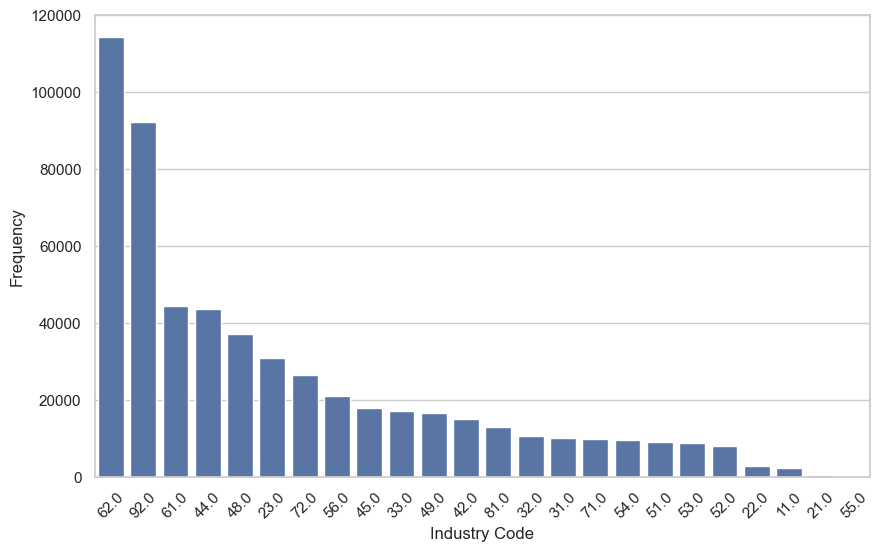

In [299]:
plot_bar(df_train, 'Industry Code',degrees=45)

- Observations
  - No unknown values/categories
- Decisions
  - None

### Medical Fee Region variable

Let's examine the key statistics for this variable:

In [300]:
df_train['Medical Fee Region'].describe()

count     574026
unique         5
top           IV
freq      265981
Name: Medical Fee Region, dtype: object

In [301]:
df_train['Medical Fee Region'].value_counts()

Medical Fee Region
IV     265981
I      135885
II      85033
III     53654
UK      33473
Name: count, dtype: int64

In [302]:
print('The Medical Fee Region variable has ' + str(df_train['Medical Fee Region'].isna().mean()*100) + '% of missing values in the train data')
print('The Medical Fee Region variable has ' + str(df_test['Medical Fee Region'].isna().mean()*100) + '% of missing values in the test data')

The Medical Fee Region variable has 3.276486972404717% of missing values in the train data
The Medical Fee Region variable has 0.0% of missing values in the test data


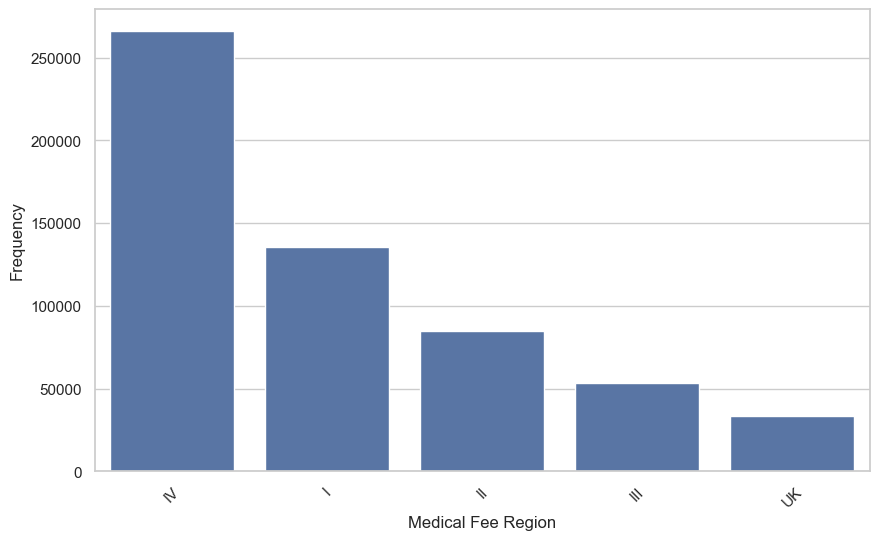

In [303]:
plot_bar(df_train, 'Medical Fee Region',degrees=45)

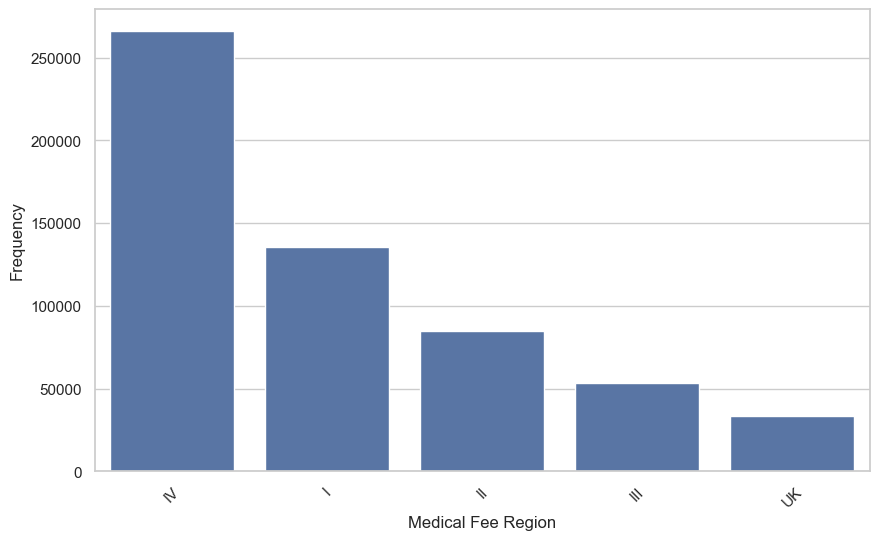

In [304]:
plot_bar(df_train, 'Medical Fee Region',degrees=45)

- Observations
  - "UK" treated as unknown values.
- Decisions
  - "UK" values as NaN

### WCIO Cause of Injury Code and WCIO Cause of Injury Description variables

Let's examine the key statistics for this variable:

In [305]:
df_train['WCIO Cause of Injury Code'].describe()

count     558386.0
unique        77.0
top           56.0
freq       46610.0
Name: WCIO Cause of Injury Code, dtype: float64

In [306]:
df_train['WCIO Cause of Injury Description'].describe()

count      558386
unique         74
top       LIFTING
freq        46610
Name: WCIO Cause of Injury Description, dtype: object

In [307]:
df_train['WCIO Cause of Injury Code'].value_counts()

WCIO Cause of Injury Code
56.0    46610
74.0    37153
60.0    33192
31.0    31733
29.0    29364
        ...  
91.0       55
14.0       51
40.0       45
8.0        34
47.0       12
Name: count, Length: 77, dtype: int64

In [308]:
df_train['WCIO Cause of Injury Description'].value_counts()

WCIO Cause of Injury Description
LIFTING                                   46610
FELLOW WORKER, PATIENT OR OTHER PERSON    37153
STRAIN OR INJURY BY, NOC                  33192
FALL, SLIP OR TRIP, NOC                   31733
ON SAME LEVEL                             29364
                                          ...  
MOLD                                         55
ABNORMAL AIR PRESSURE                        51
CRASH OF WATER VEHICLE                       45
RADIATION                                    34
CRASH OF AIRPLANE                            12
Name: count, Length: 74, dtype: int64

In [309]:
print('The WCIO Cause of Injury Code variable has ' + str(df_train['WCIO Cause of Injury Code'].isna().mean()*100) + '% of missing values in the train data')
print('The WCIO Cause of Injury Code variable has ' + str(df_test['WCIO Cause of Injury Code'].isna().mean()*100) + '% of missing values in the test data')

The WCIO Cause of Injury Code variable has 5.911830569648727% of missing values in the train data
The WCIO Cause of Injury Code variable has 2.667182163799214% of missing values in the test data


In [310]:
print('The WCIO Cause of Injury Description variable has ' + str(df_train['WCIO Cause of Injury Description'].isna().mean()*100) + '% of missing values in the train data')
print('The WCIO Cause of Injury Description variable has ' + str(df_test['WCIO Cause of Injury Description'].isna().mean()*100) + '% of missing values in the test data')

The WCIO Cause of Injury Description variable has 5.911830569648727% of missing values in the train data
The WCIO Cause of Injury Description variable has 2.667182163799214% of missing values in the test data


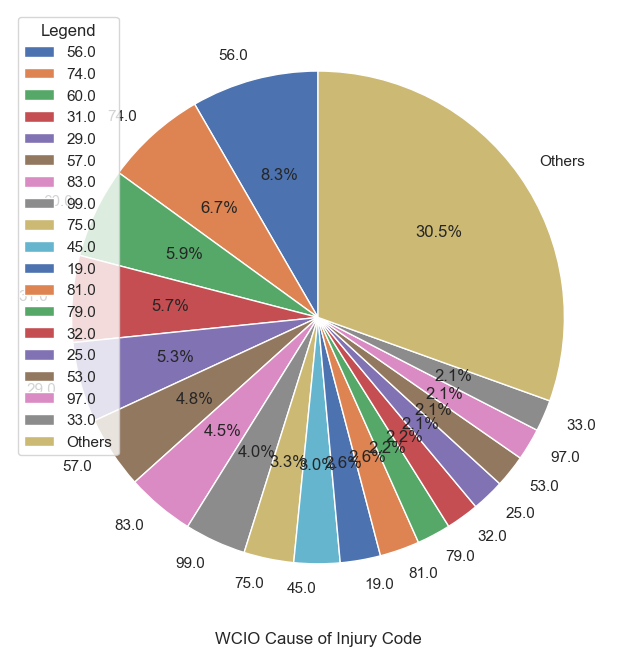

In [311]:
plot_pie(df_train, 'WCIO Cause of Injury Code')

In [312]:
# Same Description codes
print(df_train[df_train['WCIO Cause of Injury Description']=='OBJECT BEING LIFTED OR HANDLED']['WCIO Cause of Injury Code'].unique())
print(df_train[df_train['WCIO Cause of Injury Description']=='REPETITIVE MOTION']['WCIO Cause of Injury Code'].unique())

[79.0, 17.0, 66.0]
Categories (77, float64): [1.0, 2.0, 3.0, 4.0, ..., 96.0, 97.0, 98.0, 99.0]
[97.0, 94.0]
Categories (77, float64): [1.0, 2.0, 3.0, 4.0, ..., 96.0, 97.0, 98.0, 99.0]


In [313]:
df_train['WCIO Cause of Injury Description'][df_train['WCIO Cause of Injury Description'].str.contains("unknown", case=False, na=False)].unique()

array([], dtype=object)

- Observations
  - We observed multiple codes having the same description. Upon further investigation with the definition of the codes (https://www.guarantysupport.com/wp-content/uploads/2024/02/WCIO-Legacy.pdf), the code descriptions are not complete in the dataset and are truly different. No action will be taken on these same descriptions.
  - No unknown values
- Decisions
  - None

### WCIO Part of Body Code and WCIO Part of Body Description variables

Let's examine the key statistics for this variable:

In [314]:
df_train.columns

Index(['Accident Date', 'Age at Injury', 'Alternative Dispute Resolution',
       'Assembly Date', 'Attorney/Representative', 'Average Weekly Wage',
       'Birth Year', 'C-2 Date', 'C-3 Date', 'Carrier Name', 'Carrier Type',
       'Claim Identifier', 'Claim Injury Type', 'County of Injury',
       'COVID-19 Indicator', 'District Name', 'First Hearing Date', 'Gender',
       'IME-4 Count', 'Industry Code', 'Industry Code Description',
       'Medical Fee Region', 'OIICS Nature of Injury Description',
       'WCIO Cause of Injury Code', 'WCIO Cause of Injury Description',
       'WCIO Nature of Injury Code', 'WCIO Nature of Injury Description',
       'WCIO Part Of Body Code', 'WCIO Part Of Body Description', 'Zip Code',
       'Agreement Reached', 'WCB Decision', 'Number of Dependents'],
      dtype='object')

In [315]:
df_train['WCIO Part Of Body Code'].describe()

count     556944.0
unique        57.0
top           42.0
freq       51862.0
Name: WCIO Part Of Body Code, dtype: float64

In [316]:
df_train['WCIO Part Of Body Description'].describe()

count              556944
unique                 54
top       LOWER BACK AREA
freq                51862
Name: WCIO Part Of Body Description, dtype: object

In [317]:
df_train['WCIO Part Of Body Code'].value_counts()

WCIO Part Of Body Code
 42.0    51862
 53.0    47903
-9.0     42011
 38.0    37811
 36.0    36093
 35.0    31388
 55.0    24928
 90.0    22608
 56.0    18765
 34.0    18750
 33.0    15372
 60.0    14000
 18.0    13765
 14.0    12975
 37.0    12525
 54.0    11622
 31.0    11236
 91.0    10950
 32.0     9949
 41.0     8240
 10.0     7939
 11.0     7904
 44.0     7644
 61.0     6770
 51.0     6430
 66.0     6103
 25.0     5938
 65.0     5311
 52.0     4296
 13.0     3912
 19.0     3905
 48.0     3759
 20.0     2848
 30.0     2633
 39.0     2623
 57.0     2535
 15.0     2091
 63.0     1998
 12.0     1989
 50.0     1927
 43.0     1893
 58.0     1806
 40.0     1752
 17.0     1602
 21.0     1332
 99.0     1249
 62.0     1161
 22.0     1103
 16.0      803
 46.0      740
 49.0      637
 23.0      477
 47.0      402
 45.0      402
 24.0      141
 26.0       83
 64.0       53
Name: count, dtype: int64

In [318]:
df_train['WCIO Part Of Body Description'].value_counts()

WCIO Part Of Body Description
LOWER BACK AREA                                          51862
KNEE                                                     47903
MULTIPLE                                                 42011
SHOULDER(S)                                              37811
FINGER(S)                                                36093
HAND                                                     31388
ANKLE                                                    24928
MULTIPLE BODY PARTS (INCLUDING BODY                      22608
SOFT TISSUE                                              19703
FOOT                                                     18765
WRIST                                                    18750
LOWER ARM                                                15372
LUNGS                                                    14000
EYE(S)                                                   12975
THUMB                                                    12525
LOWER LEG                

In [319]:
print('The WCIO Part Of Body Code variable has ' + str(df_train['WCIO Part Of Body Code'].isna().mean()*100) + '% of missing values in the train data')
print('The WCIO Part Of Body Code variable has ' + str(df_test['WCIO Part Of Body Code'].isna().mean()*100) + '% of missing values in the test data')

The WCIO Part Of Body Code variable has 6.154807901312785% of missing values in the train data
The WCIO Part Of Body Code variable has 2.4612410593466074% of missing values in the test data


In [320]:
print('The WCIO Part Of Body Description variable has ' + str(df_train['WCIO Part Of Body Description'].isna().mean()*100) + '% of missing values in the train data')
print('The WCIO Part Of Body Description variable has ' + str(df_test['WCIO Part Of Body Description'].isna().mean()*100) + '% of missing values in the test data')

The WCIO Part Of Body Description variable has 6.154807901312785% of missing values in the train data
The WCIO Part Of Body Description variable has 2.4612410593466074% of missing values in the test data


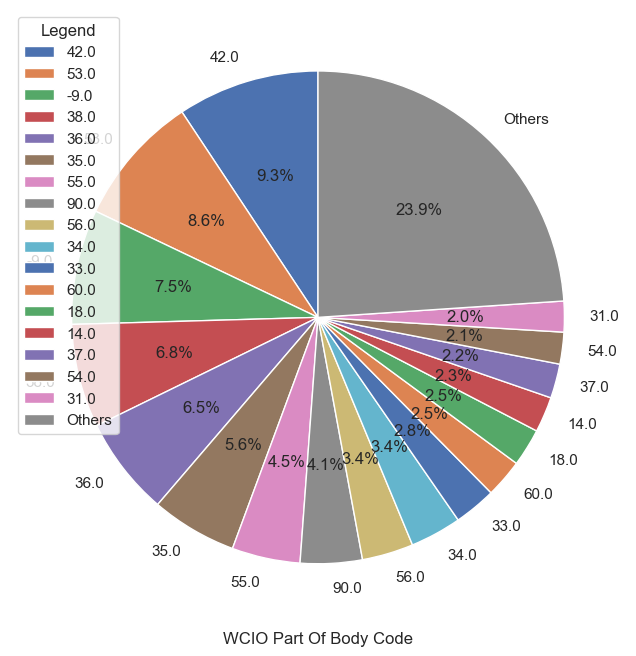

In [321]:
plot_pie(df_train, 'WCIO Part Of Body Code')

- Observations
  - Negative codes
- Decisions
  - Make negative code positive
  - Minus code for "-9.0", change to 9.0.

### ZIP Code variable

Let's examine the key statistics for this variable:

In [322]:
df_train['Zip Code'].describe()

count     545389
unique     10060
top        11236
freq        3302
Name: Zip Code, dtype: object

In [323]:
df_train['Zip Code'].value_counts()

Zip Code
11236      3302
10940      2971
11717      2807
11434      2759
11706      2728
           ... 
09603         1
13125         1
75038.0       1
14507.0       1
07122         1
Name: count, Length: 10060, dtype: int64

In [324]:
print('The Zip Code variable has ' + str(df_train['Zip Code'].isna().mean()*100) + '% of missing values in the train data')
print('The Zip Code variable has ' + str(df_test['Zip Code'].isna().mean()*100) + '% of missing values in the test data')

The Zip Code variable has 8.1018280589953% of missing values in the train data
The Zip Code variable has 4.985372768863973% of missing values in the test data


In [325]:
zip_code_counts = df_train.copy()

In [326]:
zip_code_temp = df_train["Zip Code"].dropna().astype(str)

1. Check for Negative Values

In [327]:
negative_values = zip_code_temp[zip_code_temp.str.startswith('-')]
if not negative_values.empty:
    print("Negative values found in 'Zip Code':")
    display(negative_values)

2. Check for Non-Numeric Characters


In [328]:
non_numeric = zip_code_temp[~zip_code_temp.str.match(r'^\d+$')]
if not non_numeric.empty:
    print("Non-numeric values found in 'Zip Code':")
    display(non_numeric)

Non-numeric values found in 'Zip Code':


4585      L1N 5
9359      T1B0P
9751      L6Y 1
13688     JMDMR
15048     N2P 1
          ...  
576577    V1M2B
580232    L2P0A
581907    L6L 1
583384    L1A 1
592799    G9B0Y
Name: Zip Code, Length: 15373, dtype: object

3. Check for Length Inconsistencies (assuming standard 5 digits)

In [329]:
length_inconsistent = zip_code_temp[zip_code_temp.str.len() != 5]
if not length_inconsistent.empty:
    print("Inconsistent length values found in 'Zip Code':")
    display(length_inconsistent)

Inconsistent length values found in 'Zip Code':


41789         T2V
111214        SLV
182452        L9W
228112        P7G
262144    10567.0
           ...   
420949        K9J
429765        M5R
455762        L1G
478123        J5K
553450        N8H
Name: Zip Code, Length: 15037, dtype: object

In [330]:
merged_issues = pd.concat([non_numeric, length_inconsistent]).drop_duplicates()
if not merged_issues.empty:
    print("Merged issues found in 'Zip Code':")
    display(merged_issues)
print(merged_issues.count())

Merged issues found in 'Zip Code':


4585      L1N 5
9359      T1B0P
9751      L6Y 1
13688     JMDMR
15048     N2P 1
          ...  
576577    V1M2B
580232    L2P0A
581907    L6L 1
592799    G9B0Y
334043     7006
Name: Zip Code, Length: 2006, dtype: object

2006


4. Check for Placeholder Values (any amount of zeros, e.g., '000', '00000')

In [331]:
placeholders = zip_code_temp[zip_code_temp.str.match(r'^0+$')]
if not placeholders.empty:
    print("Placeholder values found in 'Zip Code' (any amount of zeros):")
    display(placeholders)

Placeholder values found in 'Zip Code' (any amount of zeros):


44780     00000
48863     00000
73168     00000
73843     00000
77384     00000
215545    00000
324129    00000
329697    00000
527010    00000
527275    00000
540776    00000
550122    00000
561719    00000
Name: Zip Code, dtype: object

- Observations
  1. No negative values
  2. Non numerical values are OK
  3. Length inconsistent is OK
  4. Placeholder values (00..)
- Decisions
  - Make placeholders NaNs

### Claim Injury Type variable

This variable only exists in the train data

Let's examine the key statistics for this variable:

In [332]:
df_train['Claim Injury Type'].describe()

count          574026
unique              8
top       2. NON-COMP
freq           291078
Name: Claim Injury Type, dtype: object

In [333]:
df_train['Claim Injury Type'].value_counts()

Claim Injury Type
2. NON-COMP        291078
4. TEMPORARY       148507
3. MED ONLY         68906
5. PPD SCH LOSS     48280
1. CANCELLED        12477
6. PPD NSL           4211
8. DEATH              470
7. PTD                 97
Name: count, dtype: int64

In [334]:
print('The Claim Injury Type variable has ' + str(df_train['Claim Injury Type'].isna().mean()*100) + '% of missing values in the train data')

The Claim Injury Type variable has 3.276486972404717% of missing values in the train data


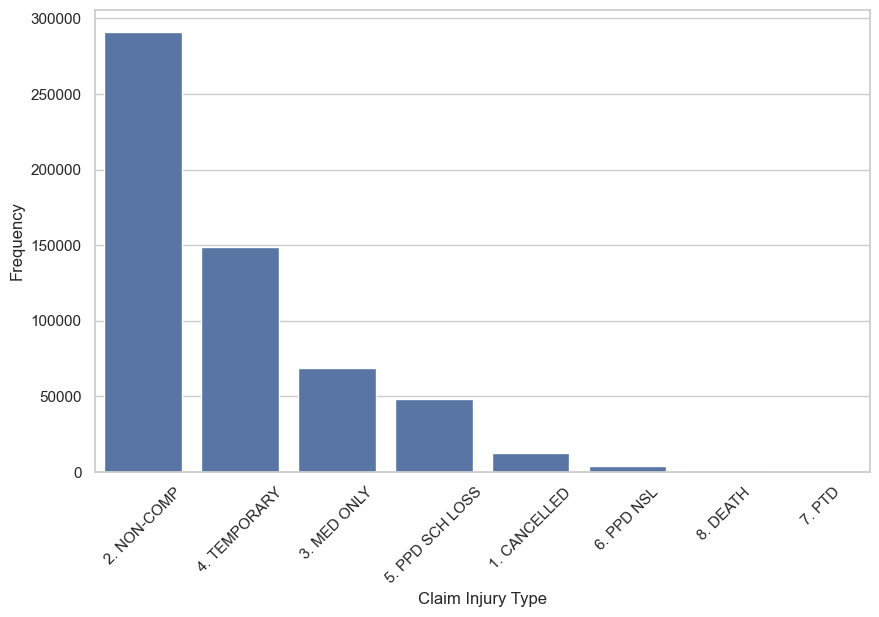

In [335]:
plot_bar(df_train, 'Claim Injury Type',degrees=45)

- Observations
  - No unknown
- Decisions
  - none

### Gender variable

Let's examine the key statistics for this variable:

In [336]:
df_train['Gender'].describe()

count     574026
unique         4
top            M
freq      335218
Name: Gender, dtype: object

In [337]:
df_train['Gender'].value_counts()

Gender
M    335218
F    234051
U      4711
X        46
Name: count, dtype: int64

In [338]:
print('The Gender variable has ' + str(df_train['Gender'].isna().mean()*100) + '% of missing values in the train data')
print('The Gender variable has ' + str(df_test['Gender'].isna().mean()*100) + '% of missing values in the test data')

The Gender variable has 3.276486972404717% of missing values in the train data
The Gender variable has 0.0% of missing values in the test data


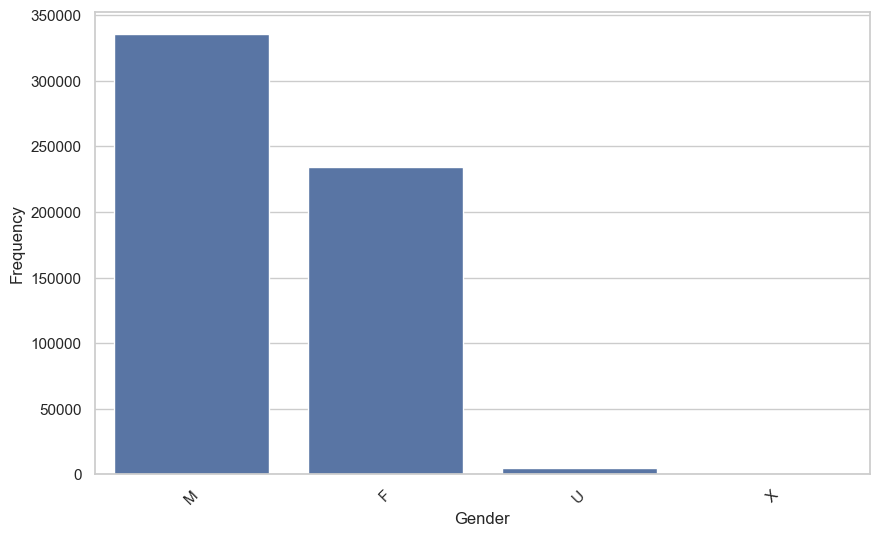

In [339]:
plot_bar(df_train, 'Gender',degrees=45)

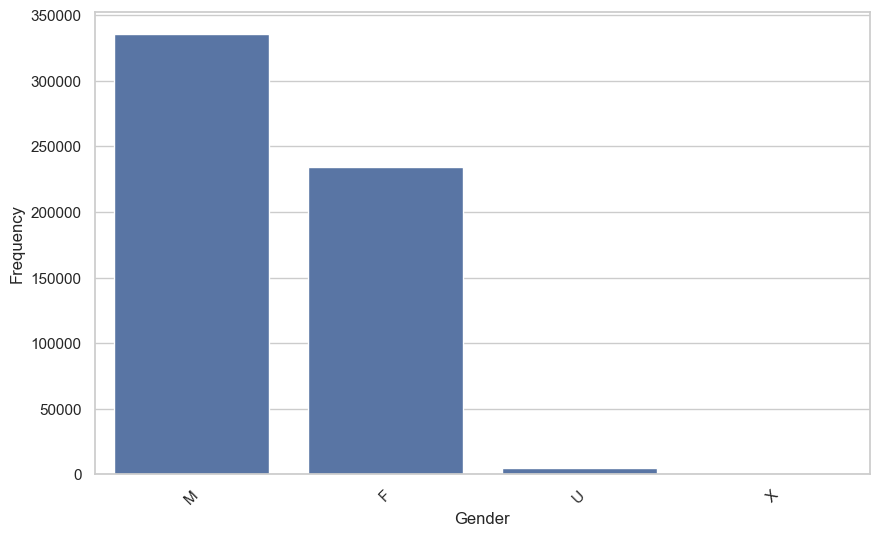

In [340]:
plot_bar(df_train, 'Gender',degrees=45)

- Observations
  - unknown values as "u"
- Decisions
  - Replace unknown with NaN

In [341]:
# Empty columns: WCB Decision (in test), OIICS Nature of Injury Description, Agreement Reached
    # Ignore those

## Multivariate analysis

### Cross-feature inconsistencies

#### Date variables order

In [342]:
def check_date_order(row):
    if row.isna().all():
        return True

    # Extraindo as datas das colunas relevantes
    accident_date = row['Accident Date']
    c2_date = row['C-2 Date']
    c3_date = row['C-3 Date']
    assembly_date = row['Assembly Date']
    hearing_date = row['First Hearing Date']

    # Checagem da ordem das datas
    # Se Accident Date e C-2 Date não forem NA, verificar a ordem
    if pd.notna(accident_date) and pd.notna(c2_date) and accident_date >= c2_date:
        return False

    # Se C-2 Date e C-3 Date não forem NA, verificar a ordem
    if pd.notna(c2_date) and pd.notna(c3_date) and c2_date >= c3_date:
        return False

    # Se C-3 Date e Assembly Date não forem NA, verificar a ordem
    if pd.notna(c3_date) and pd.notna(assembly_date) and c3_date >= assembly_date:
        return False

    # Se Assembly Date e First Hearing Date não forem NA, verificar a ordem
    if pd.notna(assembly_date) and pd.notna(hearing_date) and assembly_date >= hearing_date:
        return False

    return True

In [343]:
df_train['Order Correct'] = df_train.apply(check_date_order, axis=1)

In [344]:
df_train['Order Correct'].value_counts()

Order Correct
True     411278
False    182193
Name: count, dtype: int64

In [345]:
df_train[df_train["Order Correct"]==False][['Claim Identifier',"Accident Date","C-2 Date","C-3 Date","Assembly Date",'First Hearing Date']]

,Claim Identifier,Accident Date,C-2 Date,C-3 Date,Assembly Date,First Hearing Date
1,5393091,2019-08-30,2020-01-01,2020-01-14,2020-01-01,2020-02-21
7,5394182,2019-12-30,2019-12-31,2020-03-04,2020-01-01,NaT
15,5393826,2019-12-18,2019-12-31,2020-03-04,2020-01-01,NaT
17,5393811,2019-12-19,2020-01-01,2020-01-07,2020-01-01,2020-08-13
21,5393931,2019-09-15,2020-01-01,2020-01-03,2020-01-01,2020-03-06
...,...,...,...,...,...,...
593433,6164364,2022-11-23,2023-01-06,2022-12-21,2022-12-30,NaT
593434,6164612,2022-12-12,2023-01-04,2022-12-28,2022-12-30,NaT
593436,6165390,2022-10-24,2022-12-27,2022-12-16,2022-12-30,2023-05-05
593445,6164934,2022-12-19,2023-03-20,2022-12-27,2022-12-30,2023-04-25


#### Covid Code and indicator

In [346]:
df_train.columns

Index(['Accident Date', 'Age at Injury', 'Alternative Dispute Resolution',
       'Assembly Date', 'Attorney/Representative', 'Average Weekly Wage',
       'Birth Year', 'C-2 Date', 'C-3 Date', 'Carrier Name', 'Carrier Type',
       'Claim Identifier', 'Claim Injury Type', 'County of Injury',
       'COVID-19 Indicator', 'District Name', 'First Hearing Date', 'Gender',
       'IME-4 Count', 'Industry Code', 'Industry Code Description',
       'Medical Fee Region', 'OIICS Nature of Injury Description',
       'WCIO Cause of Injury Code', 'WCIO Cause of Injury Description',
       'WCIO Nature of Injury Code', 'WCIO Nature of Injury Description',
       'WCIO Part Of Body Code', 'WCIO Part Of Body Description', 'Zip Code',
       'Agreement Reached', 'WCB Decision', 'Number of Dependents',
       'Order Correct'],
      dtype='object')

In [347]:
df_covid=df_train.copy()
df_covid = df_covid[df_covid['WCIO Nature of Injury Code'] == 83]
df_train['covid_correct']=df_covid['COVID-19 Indicator']==True
df_train['covid_correct'].value_counts()
df_train[df_train['covid_correct']==False][['WCIO Nature of Injury Code','WCIO Nature of Injury Description','COVID-19 Indicator']]

,WCIO Nature of Injury Code,WCIO Nature of Injury Description,COVID-19 Indicator
6623,83.0,COVID-19,Y
23194,83.0,COVID-19,Y
28695,83.0,COVID-19,Y
40148,83.0,COVID-19,Y
40557,83.0,COVID-19,Y
...,...,...,...
593089,83.0,COVID-19,Y
593352,83.0,COVID-19,Y
593371,83.0,COVID-19,Y
593376,83.0,COVID-19,Y


### Multivariate Visualizations

#### Visualization 1: X by Y with Z

In [348]:
#...

The variable OIICS Nature of Injury Description does not contain information, and its removal was decided. Therefore, we omitted it from the chart for visualization.

Non-metric (Categorical) features: ['Alternative Dispute Resolution', 'Attorney/Representative', 'Carrier Name', 'Carrier Type', 'Claim Injury Type', 'County of Injury', 'COVID-19 Indicator', 'District Name', 'Gender', 'Industry Code', 'Industry Code Description', 'Medical Fee Region', 'WCIO Cause of Injury Code', 'WCIO Cause of Injury Description', 'WCIO Nature of Injury Code', 'WCIO Nature of Injury Description', 'WCIO Part Of Body Code', 'WCIO Part Of Body Description', 'Zip Code', 'WCB Decision', 'covid_correct']
Non-metric (High Cardinality) features: ['Carrier Name', 'County of Injury', 'WCIO Cause of Injury Code', 'WCIO Cause of Injury Description', 'WCIO Nature of Injury Code', 'WCIO Nature of Injury Description', 'WCIO Part Of Body Code', 'WCIO Part Of Body Description', 'Zip Code']
Metric (Numerical) features: ['Age at Injury', 'Average Weekly Wage', 'Birth Year', 'Claim Identifier', 'IME-4 Count', 'OIICS Nature of Injury Description', 'Agreement Reached', 'Number of Dependen

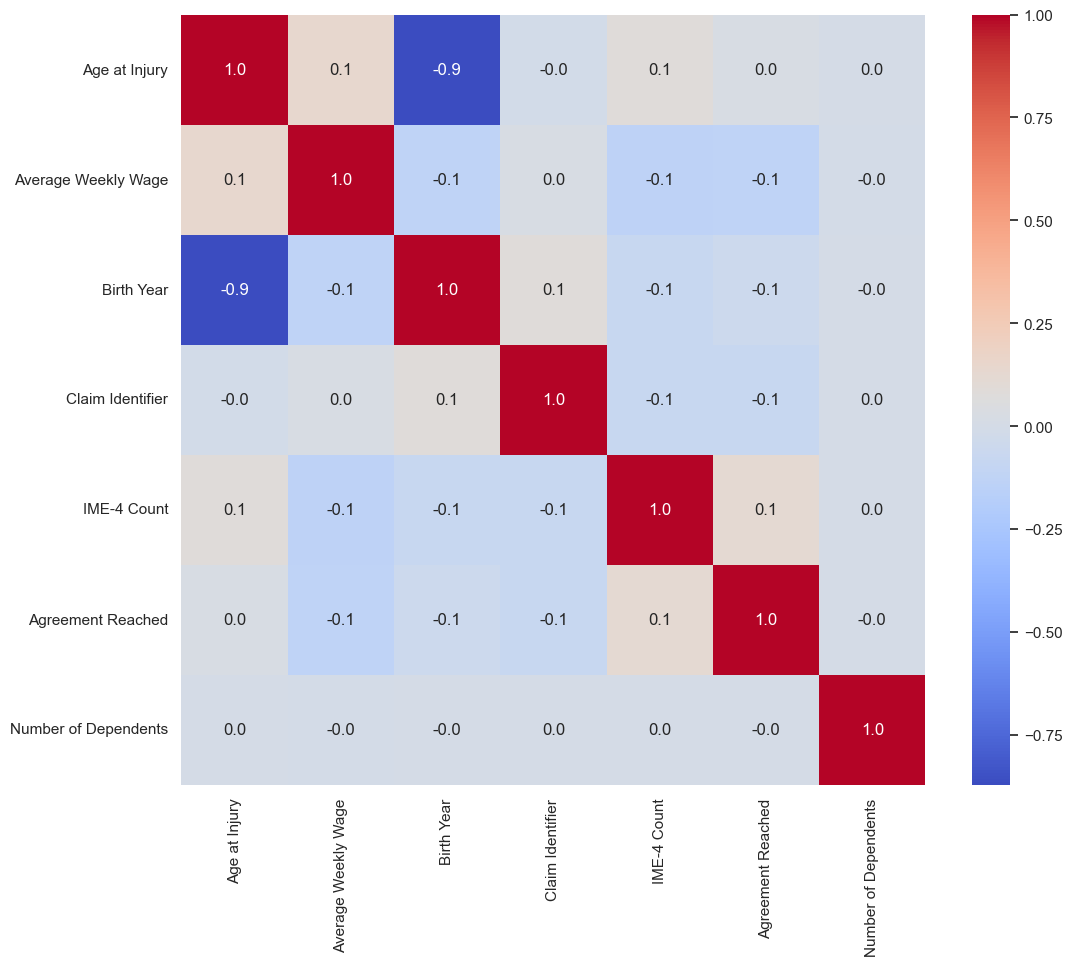

In [350]:
# Apply feature_splitting to get numerical features
date_features, non_metric_features, non_metric_high_cardinality, metric_features = feature_splitting(df_train)

# Exclude "OIICS Nature of Injury Description" from metric_features if it exists
if "OIICS Nature of Injury Description" in metric_features:
    metric_features.remove("OIICS Nature of Injury Description")

# Use the modified metric_features list in plot_heatmap
plot_heatmap(df_train, metric_features)

As expected, there is an obvious strong negative correlation between the variables age at injury and birth year, as they are directly related. Among the remaining variables, no significants correlations were observed.

Now we will transform the dates into ordered integers, so that we can include them in the metric features and visualize them in a correlation map.

Non-metric (Categorical) features: ['Alternative Dispute Resolution', 'Attorney/Representative', 'Carrier Name', 'Carrier Type', 'Claim Injury Type', 'County of Injury', 'COVID-19 Indicator', 'District Name', 'Gender', 'Industry Code', 'Industry Code Description', 'Medical Fee Region', 'WCIO Cause of Injury Code', 'WCIO Cause of Injury Description', 'WCIO Nature of Injury Code', 'WCIO Nature of Injury Description', 'WCIO Part Of Body Code', 'WCIO Part Of Body Description', 'Zip Code', 'WCB Decision', 'covid_correct']
Non-metric (High Cardinality) features: ['Carrier Name', 'County of Injury', 'WCIO Cause of Injury Code', 'WCIO Cause of Injury Description', 'WCIO Nature of Injury Code', 'WCIO Nature of Injury Description', 'WCIO Part Of Body Code', 'WCIO Part Of Body Description', 'Zip Code']
Metric (Numerical) features: ['Age at Injury', 'Average Weekly Wage', 'Birth Year', 'Claim Identifier', 'IME-4 Count', 'OIICS Nature of Injury Description', 'Agreement Reached', 'Number of Dependen

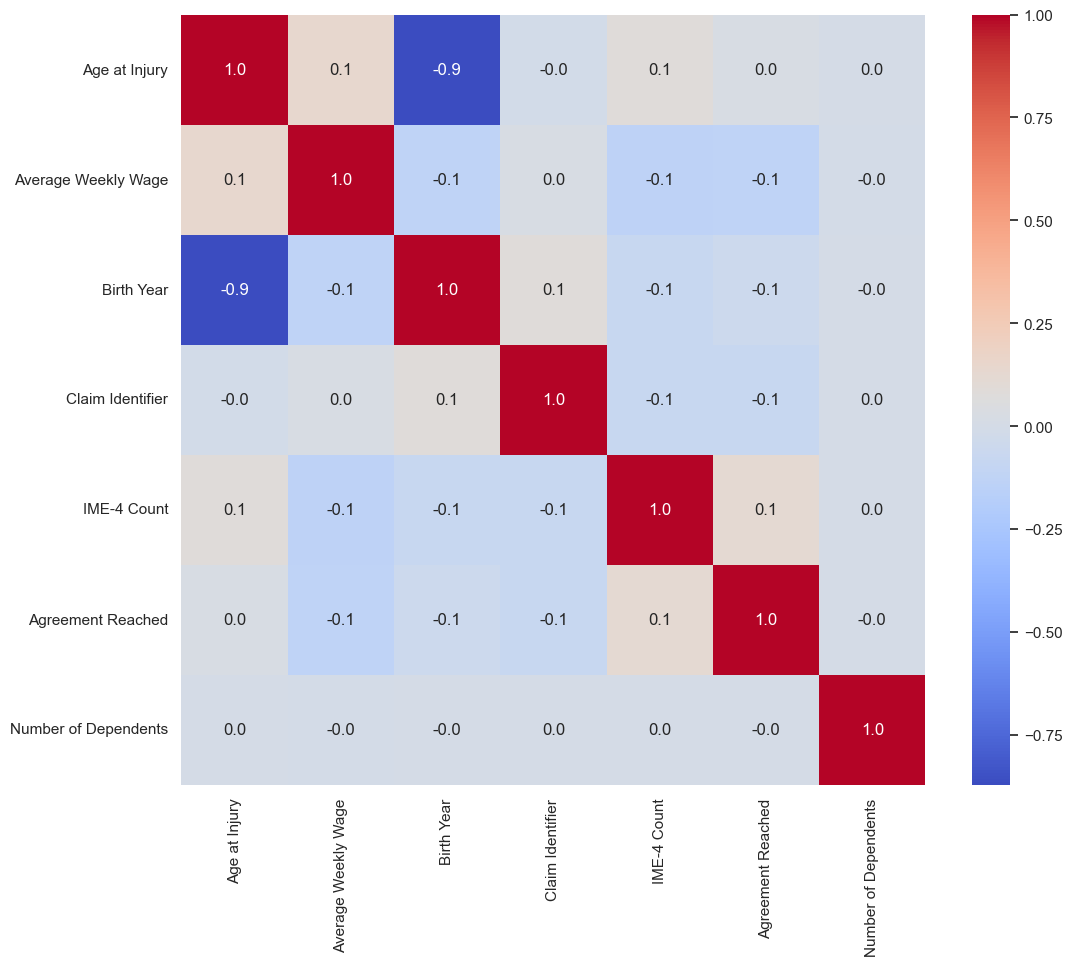

In [351]:
# Split the variables (identify numeric, categorical, etc. columns)
date_features, non_metric_features, non_metric_high_cardinality, metric_features = feature_splitting(df_train)

# Check if the transformed date columns are included in metric_features
print("Metric Features (after transformation):", metric_features)

# Eliminate 'OCCIS Nature of Injury Description' from metric_features
metric_features = [col for col in metric_features if col != 'OIICS Nature of Injury Description']

# Plot the heatmap with all numeric variables, including the transformed dates, excluding the 'OIICS Nature of Injury Description'
plot_heatmap(df_train, metric_features)

- As expected, there is a strong correlation between C-2 Date, C-3 Date, First Hearing Date, Assembly Date, and Accident Date, which makes sense as they represent different stages of the same process.
- Given the high correlation between some of these date variables (close to 1), some may be redundant. To simplify the model and reduce dimensionality, we might consider removing highly correlated variables (e.g., C-2 Date and C-3 Date, or Accident Date and Assembly Date). It may also be worth considering using just one date variable to represent time, especially the one that most effectively captures the phenomenon.
- First Hearing Date has a correlation of 0.8 with the other date variables, suggesting a distinct role. We could retain it in the model if it is relevant to the analysis context.

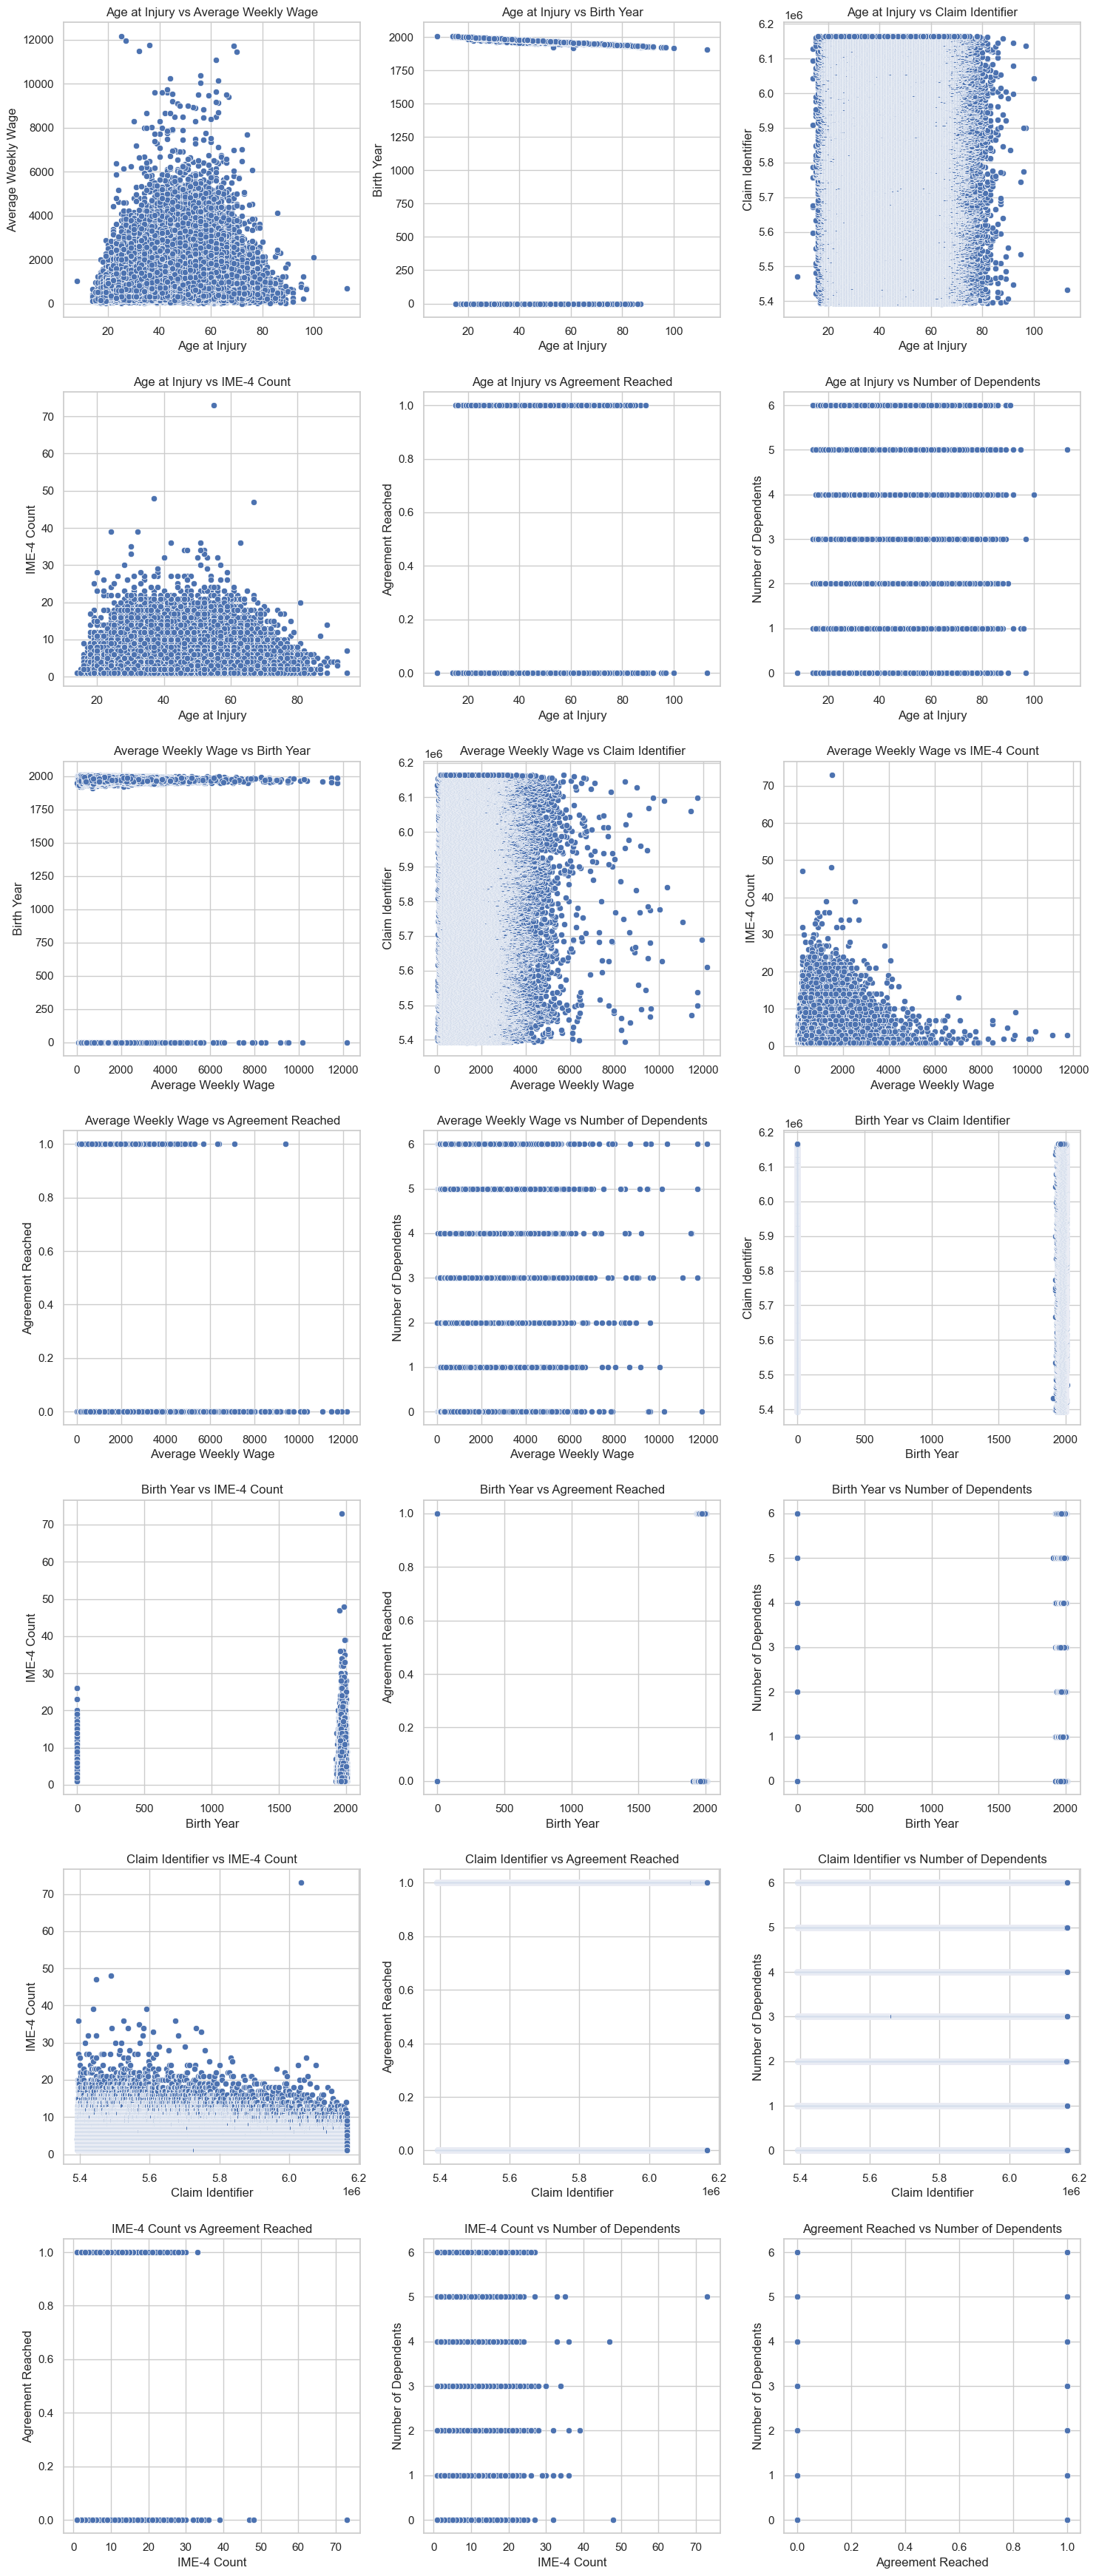

In [352]:
plot_scatter_all_subplots(df_train, metric_features)

##### Exploring the relationship between 'Gender' and 'Claim Injury Type'

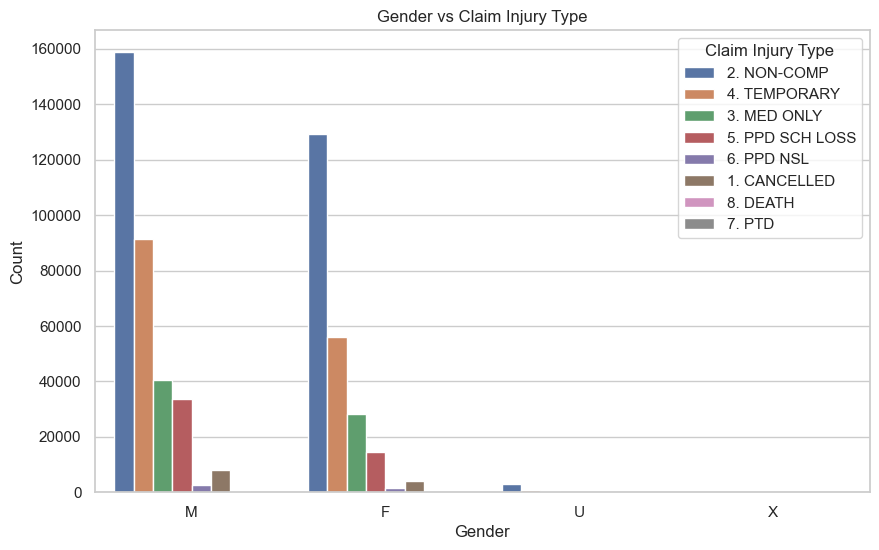

In [356]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Gender', hue='Claim Injury Type', data=df_train)
plt.title('Gender vs Claim Injury Type')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

##### Exploring the relationship between Age and Claim Injury Type

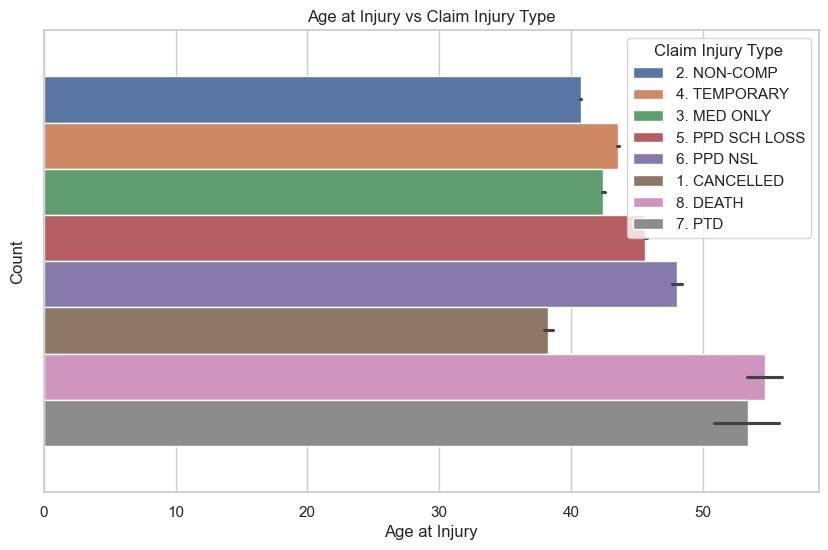

In [358]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Age at Injury', hue='Claim Injury Type', data=df_train)
plt.title('Age at Injury vs Claim Injury Type')
plt.xlabel('Age at Injury')
plt.ylabel('Count')
plt.show()

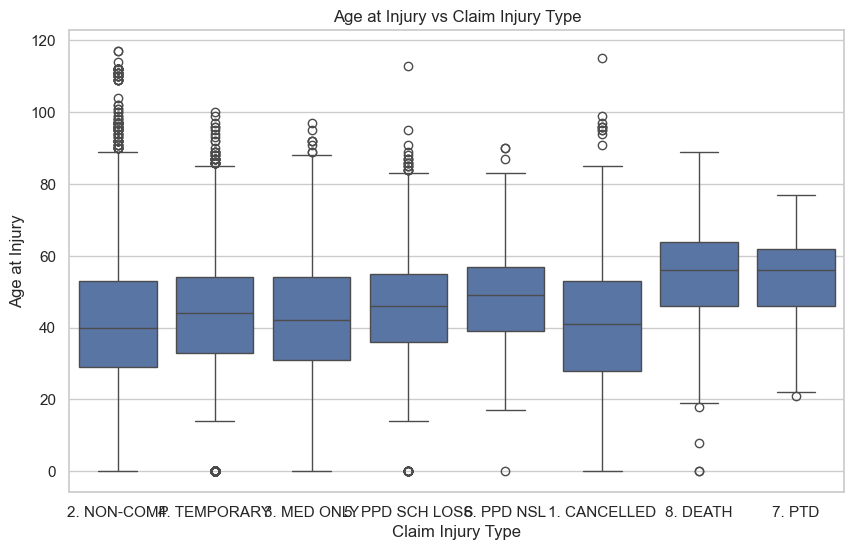

In [365]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Claim Injury Type', y='Age at Injury', data=df_train)
plt.title('Age at Injury vs Claim Injury Type')
plt.xlabel('Claim Injury Type')
plt.ylabel('Age at Injury')
plt.show()

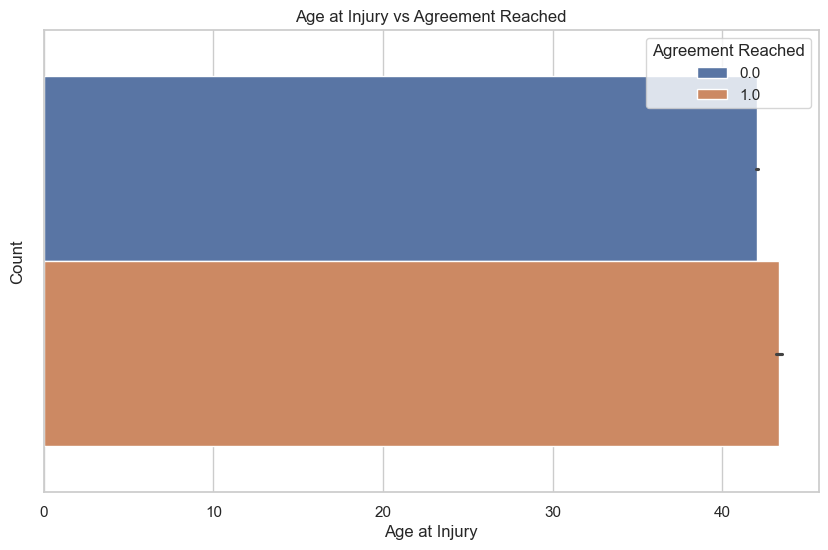

In [360]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Age at Injury', hue='Agreement Reached', data=df_train)
plt.title('Age at Injury vs Agreement Reached')
plt.xlabel('Age at Injury')
plt.ylabel('Count')
plt.show()

##### Relationship Between Age and Agreement Reached (Resolution of the Claim)

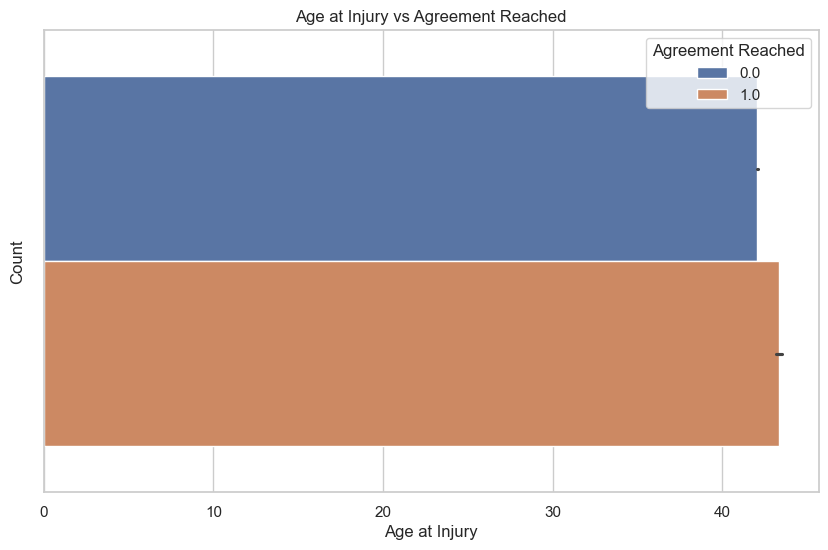

In [366]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Age at Injury', hue='Agreement Reached', data=df_train)
plt.title('Age at Injury vs Agreement Reached')
plt.xlabel('Age at Injury')
plt.ylabel('Count')
plt.show()


##### Relationship Between Injury Type and Industry Code

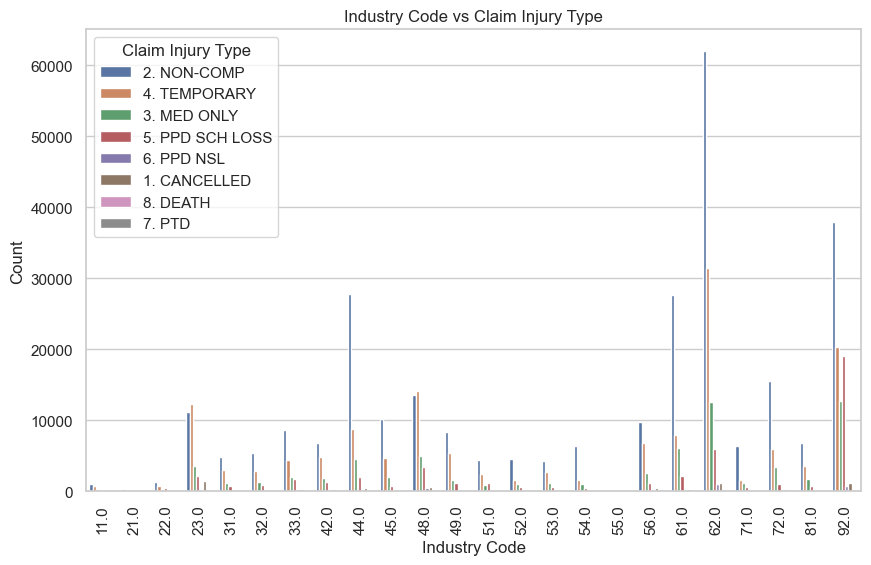

In [368]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Industry Code', hue='Claim Injury Type', data=df_train)
plt.title('Industry Code vs Claim Injury Type')
plt.xlabel('Industry Code')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

##### Relationship Between Injury Type and Medical Fee Region

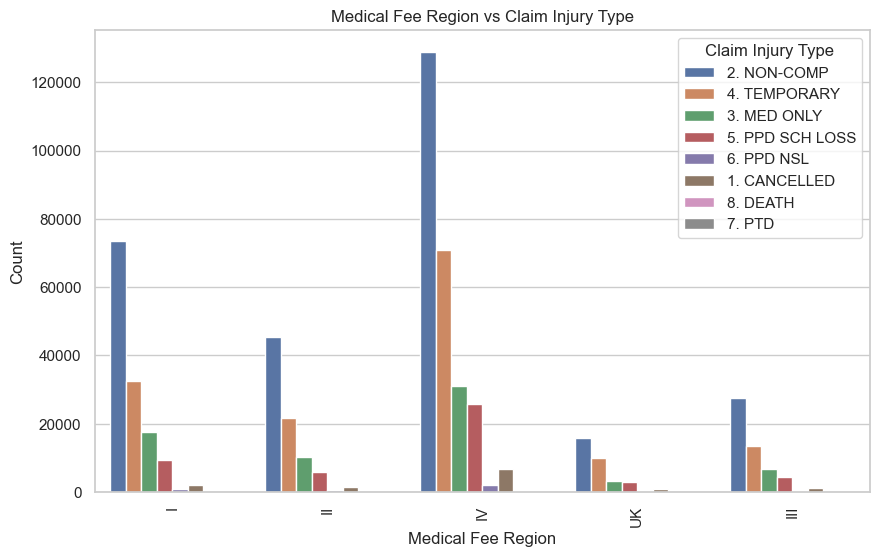

In [369]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Medical Fee Region', hue='Claim Injury Type', data=df_train)
plt.title('Medical Fee Region vs Claim Injury Type')
plt.xlabel('Medical Fee Region')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

##### Relationship Between Injury Type and District Name

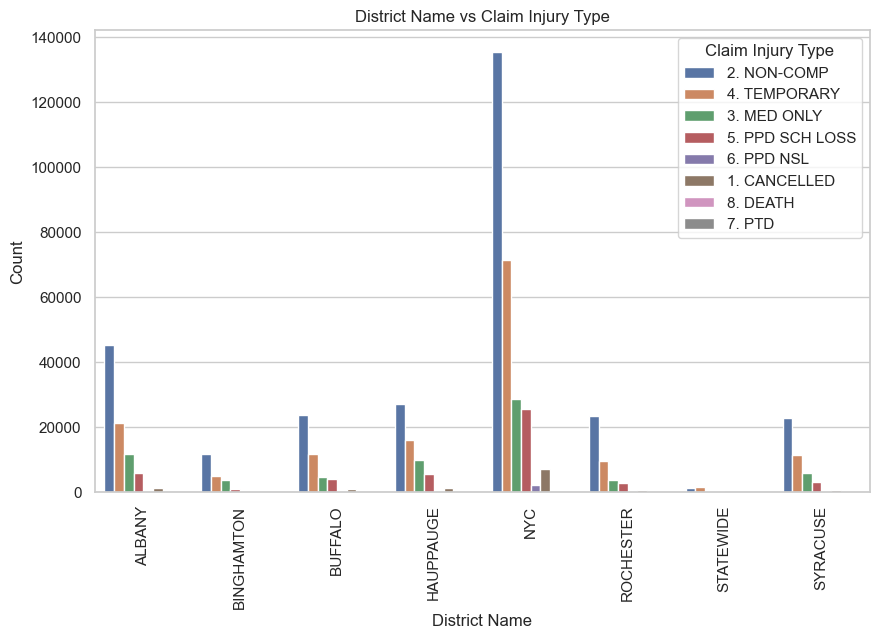

In [371]:
plt.figure(figsize=(10, 6))
sns.countplot(x='District Name', hue='Claim Injury Type', data=df_train)
plt.title('District Name vs Claim Injury Type')
plt.xlabel('District Name')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

##### COVID-19 Indicator and Claim Injury Type

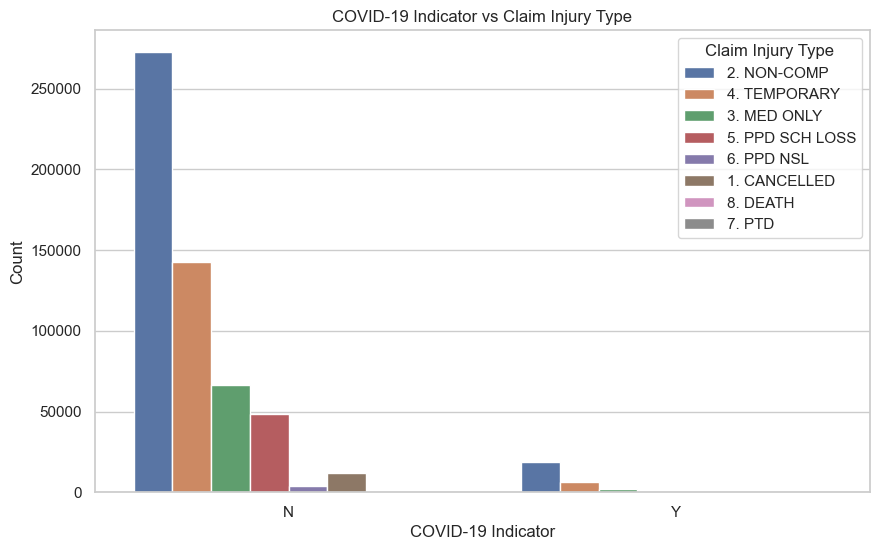

In [374]:
plt.figure(figsize=(10, 6))
sns.countplot(x='COVID-19 Indicator', hue='Claim Injury Type', data=df_train)
plt.title('COVID-19 Indicator vs Claim Injury Type')
plt.xlabel('COVID-19 Indicator')
plt.ylabel('Count')
plt.show()

##### Claim Injury Type and Attorney Representation

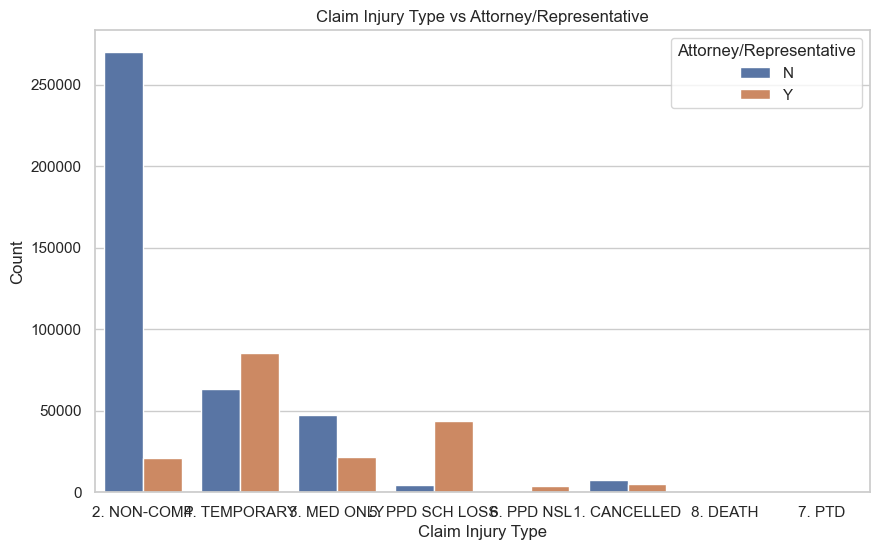

In [375]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Claim Injury Type', hue='Attorney/Representative', data=df_train)
plt.title('Claim Injury Type vs Attorney/Representative')
plt.xlabel('Claim Injury Type')
plt.ylabel('Count')
plt.show()